# Semestral project, Usage of Artificial Neural Networks in data compression
- Student: Petr Ptáček, PTA0054
- Superviser: Ing. Michal Vašinek Ph.D.

## Import of packages

In [1]:
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import time
import datetime
import string
import random
import sys
import decimal
import copy

# Pandas dataframes
import pandas as pd
# Numpy
import numpy as np 
# Tensorflow 2.10.0
import tensorflow as tf
from tensorflow.keras.utils import Sequence

# Subprocess for gzip
import subprocess

# scikit-learn
import sklearn
from sklearn.model_selection import train_test_split

# Graphing
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt

# Packages for manipulation with images
from PIL import Image

# for Iter methode
import functools
import itertools

# Warnings
import warnings

# Natural language processing
import nltk


In [2]:
# check if gpu is ready to use
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [6]:
tf.sysconfig.get_build_info() 

OrderedDict([('cpu_compiler', '/usr/bin/gcc-5'),
             ('cuda_compute_capabilities',
              ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']),
             ('cuda_version', '11.2'),
             ('cudnn_version', '8'),
             ('is_cuda_build', True),
             ('is_rocm_build', False),
             ('is_tensorrt_build', True)])

In [4]:
# Set logging level only to ERROR
tf.get_logger().setLevel("INFO")

## Definitions of constants

In [8]:
# On how many decimal ciphers to round
PRECISION = 4

# Parameter K - count of K previous bytes used to predict k + 1 byte
k = 3

# Dictionaries to map bytes to integer values
alphabet_maps = {
                "english": {int.to_bytes(i, length=1, byteorder="big"):i for i in range(0, 256)},
                "dna": 
                    {
                    int.to_bytes(65, length=1, byteorder="big"): 0, 
                    int.to_bytes(67, length=1, byteorder="big"): 1,
                    int.to_bytes(71, length=1, byteorder="big"): 2,
                    int.to_bytes(84, length=1, byteorder="big"): 3,
                    int.to_bytes(78, length=1, byteorder="big"): 4,
                    int.to_bytes(10, length=1, byteorder="big"): 5,
                    int.to_bytes(13, length=1, byteorder="big"): 6,
                    },
                }
# Inverse dictionaries to map integer values to bytes
alphabet_inverse_maps = {
                        "english": {v: k for k, v in alphabet_maps["english"].items()},
                        "dna": {v: k for k, v in alphabet_maps["dna"].items()}
                        }
# Alphabet sizes
alphabet_sizes = {"english": len(alphabet_maps["english"].keys()), "dna": len(alphabet_maps["dna"].keys())}
# Input shapes for ANN
input_shapes = {"english": (k, alphabet_sizes["english"]), "dna": (k, alphabet_sizes["dna"])}
# Output shapes for ANN
output_shapes = {"english": (1, alphabet_sizes["english"]), "dna": (1, alphabet_sizes["dna"])}
# Set actual alphabet
actual_alphabet_name = "english"
actual_alphabet_map = alphabet_maps[actual_alphabet_name]
actual_alphabet_size = alphabet_sizes[actual_alphabet_name]
actual_input_shape = input_shapes[actual_alphabet_name]
actual_output_shape = output_shapes[actual_alphabet_name]

## Functions

In [4]:
def log_to_file(filename: str, message: str):
    now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    with open(filename, mode="a") as file:
        file.write(f"{now}: {message}\n")

In [5]:
def create_test_data(filename: str, alphabet: [str], size: int = 100_000):
    with open(filename, mode="w") as file:
        for i in range(0, size):
            file.write(alphabet[i % len(alphabet)])
    

In [6]:
def calculate_accuracy(pred_y, data_y, alphabet_size = 256, alphabet_map = english_map_inverse):
    right = 0
    for i in range(0, len(pred_y)):
        right += 1 if list(data_y[i])[0] == alphabet_map[np.argmax(pred_y[i])] else 0 
        
    accuracy = right / len(pred_y)
    accuracy = round(accuracy, PRECISION)
    print(f"Accuracy: {accuracy}")
    return accuracy

In [7]:
def calculate_predicted_size(pred_y, test_y, alphabet_map=english_map):
    predicted_size_in_bits = 0
    for i, prediction in enumerate(pred_y):
        prob_of_actual_char = prediction[0][alphabet_map[test_y[i][0]]]
        predicted_size_in_bits -=  1 * np.log2(prob_of_actual_char, where=prob_of_actual_char>0)
    return predicted_size_in_bits

In [8]:
# https://en.wikipedia.org/wiki/Data_compression_ratio
def calculate_compression_ratio(original_size, predicted_compressed_size):
    return round(original_size / predicted_compressed_size, PRECISION)

In [9]:
def calculate_space_saving(original_size, predicted_compressed_size):
    return round(1 - (predicted_compressed_size / original_size), PRECISION)

In [10]:
def load_data_binary(pattern: str, shuffle: bool = False, seed:int = None, lengthOfSubstring: int = 3, portion: float = 1.0, max_size_in_bytes: int = 5_000_000) -> ([],[]):
    train_x = []
    train_y = []
    
    # Get list of filenames from pattern
    filenames = tf.data.Dataset.list_files(pattern, shuffle=shuffle, seed=seed)
    filenames = [i.numpy() for i in filenames]
    filenames = random.sample(filenames, int(len(filenames) * portion))
    #print(filenames)
    # Set initial file_index and position in file.
    position_in_file = 0
    file_index = 0
    loaded_size = 0
    loaded_bytes = 0
    
    print(f"Loaded bytes [{round(loaded_bytes / max_size_in_bytes * 100, PRECISION)} %]\r", end="")
    #print(f'Loading gutenberg dataset [{round( (file_index) / len(filenames) * 100, 1)} %]\r', end="")
    # File Loop
    while file_index < len(filenames):
        # Open File
        with open(filenames[file_index], mode="rb") as file:
            # Add size
            loaded_size += os.fstat(file.fileno()).st_size
            
            file.seek(position_in_file)
            byte_x = [file.read(1) for i in range(0, lengthOfSubstring)] #file.read(lengthOfSubstring)
            byte_y = [file.read(1)]
            # Main read loop
            while True:
                # If end of file
                if b'' in byte_x or b'' in byte_y:
                    file_index += 1
                    position_in_file = 0
                    break
                else:
                    train_x.append(byte_x)
                    train_y.append(byte_y)
                    # Read like this: "Hello world!" -> ("Hel","l"), ("ell","o"), ("llo"," "), ...
                    position_in_file += 1
                    file.seek(position_in_file)
                    byte_x = [file.read(1) for i in range(0, lengthOfSubstring)] #file.read(lengthOfSubstring)
                    byte_y = [file.read(1)]
                    loaded_bytes += 1
                    if loaded_bytes >= max_size_in_bytes:
                        break
                        
        print(f"Loaded bytes [{round(loaded_bytes / max_size_in_bytes * 100, PRECISION)} %]\r", end="")
        if loaded_bytes >= max_size_in_bytes:
            break
        #print(f'Loading dataset by files [{round( (file_index) / len(filenames) * 100, 1)} %]\r', end="")
        
        #print(f'Loaded bytes [{loaded_bytes} / {max_size_in_bytes}]\r',end="")
                    
    return train_x, train_y, loaded_size



In [11]:
def experiment(train_x, train_y, val_x, val_y, test_x, test_y, model, weight_filepath, model_filepath, original_size_in_bits, batch_size=128, epochs=10, shuffle=True, x_alphabetSize=alphabetSize, y_alphabetSize=alphabetSize, x_alphabet=alphabet, y_alphabet=alphabet, k=k):
    # Train Model
    history = train_model(train_x, train_y, val_x, val_y, model, weight_filepath, model_filepath, batch_size, epochs, shuffle, x_alphabetSize, y_alphabetSize, x_alphabet, y_alphabet)
    
    # Make Predictions
    pred_y = make_predictions(test_x, test_y, model, weight_filepath, batch_size)
    
    # Calculate test accuracy
    y_inverse_alphabet = {v: k for k, v in y_alphabet.items()}
    test_accuracy = calculate_accuracy(pred_y, test_y, alphabet_size=y_alphabetSize, alphabet_map=y_inverse_alphabet)
    
    # Calculate predicted compressed size
    predicted_size_in_bits = calculate_predicted_size(pred_y, test_y, alphabet)
    
    # Calculate size of model, weights, biases in bits
    model_size_in_bits = get_dir_size(model_filepath)
    
    # Make Report
    make_report(history, original_size_in_bits, predicted_size_in_bits, model_size_in_bits, 
                epochs=epochs, batch_size=batch_size, shuffle=shuffle, test_accuracy=test_accuracy, model_name=model.name, 
                optimizer_name=str(model.optimizer).split(" ")[0].split(".")[4], k=k)

In [12]:
def train_model(train_x, train_y, val_x, val_y, model, weight_filepath, model_filepath, batch_size, epochs, shuffle=True, x_alphabetSize=alphabetSize_english,
                y_alphabetSize=alphabetSize_english, x_alphabet=english_map, y_alphabet=english_map):
    # Create checkpoint for storing only best results
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=weight_filepath,
        save_weights_only=True,
        monitor='loss',
        mode='auto',
        save_best_only=True)

    train_gen = DataGenerator(train_x, train_y, batch_size, x_num_classes=x_alphabetSize, y_num_classes=y_alphabetSize, x_alphabet=x_alphabet, y_alphabet=y_alphabet)
    val_gen = DataGenerator(val_x, val_y, batch_size, x_num_classes=x_alphabetSize, y_num_classes=y_alphabetSize, x_alphabet=x_alphabet, y_alphabet=y_alphabet)

    # Shuffle train data at start of each epoch
    # Fit model.
    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[model_checkpoint_callback], shuffle=shuffle, verbose=1)
    
    # Save trained weights and biases.
    model.save(model_filepath)

    # Show train history
    show_history(history)
    
    return history
    

In [13]:
def make_predictions(test_x, test_y, model, weight_filepath, batch_size):
    # Load best setup
    model.load_weights(weight_filepath)

    # Make predictions on data
    test_gen = DataGenerator(test_x, test_y, batch_size)
    pred_y = model.predict(test_gen)
    return pred_y

In [14]:
def make_report(history, original_size_in_bits, predicted_size_in_bits, model_size_in_bits, epochs, batch_size, shuffle, test_accuracy, k=k, model_name="", optimizer_name="", metric="loss", filename=r"./logs/experiment_specifics_log.txt"):
    # Make report
    min_loss_index = np.argmin(history.history[metric])
    min_loss = round(history.history["loss"][min_loss_index], PRECISION)
    max_train_accuracy = round(history.history["categorical_accuracy"][min_loss_index], PRECISION)
    max_validation_accuracy = round(history.history["val_categorical_accuracy"][min_loss_index], PRECISION)
    
    compression_ratio = calculate_compression_ratio(original_size_in_bits, predicted_size_in_bits)
    space_saving = calculate_space_saving(original_size_in_bits, predicted_size_in_bits)
    
    record = f"| {model_name} | {k} | {epochs} | {batch_size} | {optimizer_name} | {shuffle} | {f'{{:.{PRECISION}f}}'.format(max_train_accuracy)}\
 / {f'{{:.{PRECISION}f}}'.format(max_validation_accuracy)} / {f'{{:.{PRECISION}f}}'.format(test_accuracy)}\
 | {f'{{:.{PRECISION}f}}'.format(min_loss)} | {f'{{:.{PRECISION}f}}'.format(compression_ratio)}\
 | {f'{{:.{PRECISION}f}}'.format(space_saving)} | {f'{{:.{PRECISION}f}}'.format(original_size_in_bits)}\
 | {f'{{:.{PRECISION}f}}'.format(predicted_size_in_bits)} | {f'{{:.{PRECISION}f}}'.format(model_size_in_bits)} |"
    #| Dense 0 | 1 | 10 | 32 | Adam | True | 0.2999 / 0.2868 / 0.2979 | 2.3602 | 2.3108 | 0.5673 | 1841350.0697 | | 903160.2500
    # Log to file
    log_to_file(filename, record)
    

In [15]:
def get_dir_size(path='.'):
    total = 0
    with os.scandir(path) as it:
        for entry in it:
            if entry.is_file():
                total += entry.stat().st_size
            elif entry.is_dir():
                total += get_dir_size(entry.path)
    return total

In [16]:
def get_alphabet(data_x, data_y):
    alp = set()
    for y in data_y:
        for _y in y:
            alp.add(_y)
    for x in data_x:
        for _x in x:
            alp.add(_x)
    return alp

In [17]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

## Classes

In [18]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size, x_num_classes=256, y_num_classes=256, x_alphabet=english_map, y_alphabet=english_map):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.x_alphabet = x_alphabet
        self.y_alphabet = y_alphabet
        self.x_num_classes = x_num_classes
        self.y_num_classes = y_num_classes

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
       
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        # From bytes to Int in range <0, 255>
        #batch_x = np.array([[int.from_bytes(x, byteorder="big") for x in batch_x[i]] for i in range(0, len(batch_x))])
        #batch_y = np.array([[int.from_bytes(y, byteorder="big") for y in batch_y[i]] for i in range(0, len(batch_y))])
        batch_x = np.array([[self.x_alphabet[x] for x in batch_x[i]] for i in range(0, len(batch_x))])
        batch_y = np.array([[self.y_alphabet[y] for y in batch_y[i]] for i in range(0, len(batch_y))])
        
        # From integers to vectors of size 256, one hot encoding
        batch_x = np.array([tf.keras.utils.to_categorical(x, num_classes=self.x_num_classes) for x in batch_x])
        batch_y = np.array([tf.keras.utils.to_categorical(y, num_classes=self.y_num_classes) for y in batch_y])
        
        # Return sizes are (batch_size, 3, 256), (batch_size, 1, 256)
        return batch_x, batch_y

In [19]:
class ArithmeticDecimalCoder:
    def __init__(self, probability_table):
        """
        probability_table: Table as dictionary where key is the byte from alphabet <0, 255> and the valus is the probability
        """
        self.probability_table = probability_table
   
    def process_stage(self, probability_table, stage_min, stage_max):
            """
            Processing a stage in the encoding/decoding process.
            probability_table: The probability table.
            stage_min: The minumim probability of the current stage.
            stage_max: The maximum probability of the current stage.

            Returns the probabilities in the stage.
            """
            stage_probabilities = {}
            stage_domain = stage_max - stage_min
            
            for byte_index, (byte, probability) in enumerate(probability_table.items()):
                byte_probability = decimal.Decimal(probability)
                byte_cumulative_probability = byte_probability * stage_domain + stage_min
                stage_probabilities[byte] = [stage_min, byte_cumulative_probability]
                stage_min = byte_cumulative_probability
            return stage_probabilities
        
    def encode(self, data, probability_table):
        """
        Encodes a message using arithmetic encoding.
        
        data: String to be encoded.
        probability_table: Table as dictionary where key is the byte from alphabet <0, 255> and the valus is the probability
        
        Returns the encoder, the floating-point value representing the encoded message, and the maximum and minimum values of the interval in which the floating-point value falls.
        """
        def get_encoded_value(last_stage_probabilities):
            """
            After encoding the entire message, this method returns the single value that represents the entire message.
            last_stage_probs: A list of the probabilities in the last stage.

            Returns the minimum and maximum probabilites in the last stage in addition to the value encoding the message.
            """
            last_stage_probabilities = list(last_stage_probabilities.values())
            last_stage_values = []
            for sublist in last_stage_probabilities:
                for element in sublist:
                    last_stage_values.append(element)

            last_stage_min = min(last_stage_values)
            last_stage_max = max(last_stage_values)
            encoded_value = (last_stage_min + last_stage_max) / 2

            return last_stage_min, last_stage_max, encoded_value
        
        
        
        # To list
        #data = list(data)
        # To bytes
        #data = [int.to_bytes(x, length=1, byteorder="big") for x in data]
        
        encoder = []
        stage_min = decimal.Decimal(0.0)
        stage_max = decimal.Decimal(1.0)
        
        # Loop for each element in list
        for data_index in range(0, len(data)):
            byte = data[data_index]
            
            stage_probabilities = self.process_stage(probability_table, stage_min, stage_max)
            
            stage_min = stage_probabilities[byte][0]
            stage_max = stage_probabilities[byte][1]
            
        # Get probabilities from last stage
        last_stage_probabilities = self.process_stage(probability_table, stage_min, stage_max)
        
        # Get encoded data
        interval_min_value, interval_max_value, encoded_data = get_encoded_value(last_stage_probabilities)
        
        return encoded_data, encoder, interval_min_value, interval_max_value

    def decode(self, data, probability_table, data_length):
        """
        Decodes a message from a floating-point number.
        
        encoded_msg: The floating-point value that encodes the message.
        msg_length: Length of the message.
        probability_table: The probability table.
        Returns the decoded message.
        """
        
        decoder = []
        
        decoded_data = []
        stage_min = decimal.Decimal(0.0)
        stage_max = decimal.Decimal(1.0)
        
        for index in range(0, data_length):
            stage_probabilities = self.process_stage(probability_table, stage_min, stage_max)
            for key, value in stage_probabilities.items():
                if data >= value[0] and data <= value[1]:
                    break
            
            decoded_data.append(key)
            
            stage_min = stage_probabilities[key][0]
            stage_max = stage_probabilities[key][1]
            
        return decoded_data, decoder

## Models

### Dense ANN

#### Model 0

In [20]:
def create_dense_model_0(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False)):
    # Create model of dense ANN
    input_layer = tf.keras.Input(shape=inputShape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)

    dense_layer1 = tf.keras.layers.Dense(1024, activation="relu")(flatten_layer1)
    #dense_layer1 = tf.keras.layers.Dropout(0.2)(dense_layer1)

    dense_layer2 = tf.keras.layers.Dense(256, activation="relu")(dense_layer1)
    #dense_layer2 = tf.keras.layers.Dropout(0.2)(dense_layer2)

    output_layer = tf.keras.layers.Dense(alphabetSize, activation="softmax",)(dense_layer2)
    output_layer = tf.keras.layers.Reshape(outputShape)(output_layer)

    # Create model
    dense_model_0 = tf.keras.Model(input_layer, output_layer)
    dense_model_0._name = "Dense_0"
    
    # Compile Model
    dense_model_0.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model_0


#### Model 1

In [21]:
def create_dense_model_1(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False)):
    # Create model of dense ANN
    input_layer = tf.keras.Input(shape=inputShape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer1 = tf.keras.layers.Dense(64, activation="relu")(flatten_layer1)
    #dense_layer1 = tf.keras.layers.Dense(512, activation="relu")(flatten_layer1)
    #dense_layer1 = tf.keras.layers.Dropout(0.2)(dense_layer1)
    
    dense_layer2 = tf.keras.layers.Dense(32, activation="relu")(dense_layer1)
    #dense_layer2 = tf.keras.layers.Dense(256, activation="relu")(dense_layer1)
    #dense_layer2 = tf.keras.layers.Dropout(0.2)(dense_layer2)

    output_layer = tf.keras.layers.Dense(alphabetSize, activation="softmax",)(dense_layer2)
    output_layer = tf.keras.layers.Reshape(outputShape)(output_layer)

    # Create model
    dense_model_1 = tf.keras.Model(input_layer, output_layer)
    dense_model_1._name = "Dense_1"
    # Compile model
    dense_model_1.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    return dense_model_1

#### Model 2

In [22]:
def create_dense_model_2(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False)):
    # Create model of dense ANN
    input_layer = tf.keras.Input(shape=inputShape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer1 = tf.keras.layers.Dense(32, activation="relu")(flatten_layer1)

    output_layer = tf.keras.layers.Dense(alphabetSize, activation="softmax",)(dense_layer1)
    output_layer = tf.keras.layers.Reshape(outputShape)(output_layer)

    # Create model
    dense_model_2 = tf.keras.Model(input_layer, output_layer)
    dense_model_2._name = "Dense_2"
    # Compile model
    dense_model_2.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    return dense_model_2

### Recurrent ANN

#### Model 0

In [23]:
def create_recurrent_model_0(optimizer=tf.keras.optimizers.RMSprop()):
    # Model 0
    # Create model of recurent ANN
    input_layer = tf.keras.Input(shape=inputShape)

    lstm_layer1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation="relu", return_sequences=True))(input_layer)
    gru_layer1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, activation="relu", return_sequences=True))(lstm_layer1)

    flatten_layer1 = tf.keras.layers.Flatten()(gru_layer1)

    dense_layer1 = tf.keras.layers.Dense(256, activation="relu")(flatten_layer1)

    output_layer = tf.keras.layers.Dense(alphabetSize, activation="softmax",)(dense_layer1)
    output_layer = tf.keras.layers.Reshape(outputShape)(output_layer)

    # Create model
    recurrent_model_0 = tf.keras.Model(input_layer, output_layer)
    recurrent_model_0._name = "Recurrent_0"
    
    # Compile model
    recurrent_model_0.compile(optimizer=optimizer,
                        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                        metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    return recurrent_model_0

#### Model 1

In [24]:
def create_recurrent_model_1(optimizer=tf.keras.optimizers.RMSprop()):
    # Model 1
    # Create model of recurent ANN
    input_layer = tf.keras.Input(shape=inputShape)

    #flatten_layer1 = tf.keras.layers.Flatten()(input_layer)

    lstm_layer1 = (tf.keras.layers.LSTM(32, activation="tanh", recurrent_activation="sigmoid", recurrent_dropout=0,
                                        stateful=False, return_sequences=True))(input_layer)
    gru_layer1 = (tf.keras.layers.GRU(32, activation="tanh", recurrent_activation="sigmoid", recurrent_dropout=0,
                                        stateful=False, return_sequences=True))(lstm_layer1)

    flatten_layer1 = tf.keras.layers.Flatten()(gru_layer1)

    dense_layer1 = tf.keras.layers.Dense(32, activation="relu")(flatten_layer1)
    
    output_layer = tf.keras.layers.Dense(alphabetSize, activation="softmax",)(dense_layer1)
    output_layer = tf.keras.layers.Reshape(outputShape)(output_layer)

    # Create model
    recurrent_model_1 = tf.keras.Model(input_layer, output_layer)
    recurrent_model_1._name = "Recurrent_1"

    # Compile Model
    recurrent_model_1.compile(optimizer=optimizer,
                        loss=tf.keras.losses.CategoricalCrossentropy(),
                        metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    return recurrent_model_1

#### Model 2

In [25]:
def create_recurrent_model_2(optimizer=tf.keras.optimizers.RMSprop()):
    # Model 2
    # Create model of recurent ANN
    input_layer = tf.keras.Input(shape=inputShape)

    gru_layer1 = (tf.keras.layers.GRU(32, activation="relu", return_sequences=True))(input_layer)

    flatten_layer1 = tf.keras.layers.Flatten()(gru_layer1)
    
    dense_layer1 = tf.keras.layers.Dense(16, activation="relu")(flatten_layer1)
        
    output_layer = tf.keras.layers.Dense(alphabetSize, activation="softmax",)(dense_layer1)
    output_layer = tf.keras.layers.Reshape(outputShape)(output_layer)
    
    # Create model
    recurrent_model_2 = tf.keras.Model(input_layer, output_layer)
    recurrent_model_2._name = "Recurrent_2"

    # Compile Model
    recurrent_model_2.compile(optimizer=optimizer,
                        loss=tf.keras.losses.CategoricalCrossentropy(),
                        metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    return recurrent_model_2

#### Model 3

In [26]:
def create_recurrent_model_3(optimizer=tf.keras.optimizers.RMSprop()):
    # Model 2
    # Create model of recurent ANN
    input_layer = tf.keras.Input(shape=inputShape)

    lstm_layer1 = (tf.keras.layers.LSTM(8, activation="relu", return_sequences=True))(input_layer)

    flatten_layer1 = tf.keras.layers.Flatten()(lstm_layer1)
    
    dense_layer1 = tf.keras.layers.Dense(16, activation="relu")(flatten_layer1)
        
    output_layer = tf.keras.layers.Dense(alphabetSize, activation="softmax",)(dense_layer1)
    output_layer = tf.keras.layers.Reshape(outputShape)(output_layer)
    
    # Create model
    recurrent_model_3 = tf.keras.Model(input_layer, output_layer)
    recurrent_model_3._name = "Recurrent_3"

    # Compile Model
    recurrent_model_3.compile(optimizer=optimizer,
                        loss=tf.keras.losses.CategoricalCrossentropy(),
                        metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    return recurrent_model_3

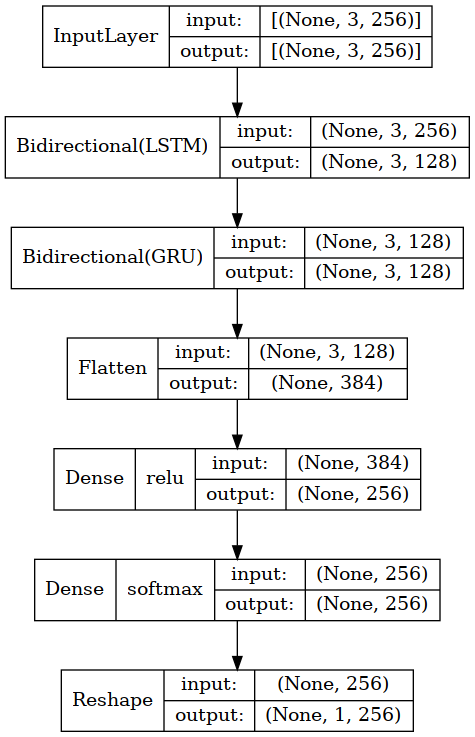

In [30]:
m = create_recurrent_model_0()
tf.keras.utils.plot_model(m, to_file=r"./recurrent_model_0.png", show_shapes=True, show_layer_activations=True, show_layer_names=False)

## Test dataset containing repeating sequences

### Load Data

In [23]:
# Create repeating sequences
create_test_data("./data/test_train.txt", ["a", "b", "c"], 100_000)
create_test_data("./data/test_test.txt", ["a", "b", "c"], 20_000)

In [19]:
# Load test_x and test_y in bytes 
test_x, test_y = load_data_binary("./data/test_test.txt", seed=42, lengthOfSubstring=3, portion=1)
test_x = np.array(test_x)
test_y = np.array(test_y)
print(f"\nSize of test dataset: {len(test_y)} [{sys.getsizeof(test_x) + sys.getsizeof(test_y)} B]")

Loading gutenberg dataset [100.0 %]
Size of test dataset: 19997 [80244 B]


In [20]:
# Load train_x and train_y in bytes
train_x, train_y = load_data_binary("./data/test_train.txt", seed=42, lengthOfSubstring=3, portion=1)
train_x = np.array(train_x)
train_y = np.array(train_y)
print(f"\nSize of train dataset: {len(train_y)} [{sys.getsizeof(train_x) + sys.getsizeof(train_y)} B]")

Loading gutenberg dataset [100.0 %]
Size of train dataset: 99997 [400244 B]


In [21]:
# Split train set into - train and validation set
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [22]:
print(f"Train data: {round(len(train_y) / (len(test_y) + len(train_y) + len(val_y)) * 100, 2) } %")
print(f"Validation data: {round(len(val_y) / (len(test_y) + len(train_y) + len(val_y)) * 100, 2) } %")
print(f"Test data: {round(len(test_y) / (len(test_y) + len(train_y) + len(val_y)) * 100, 2) } %")

Train data: 66.67 %
Validation data: 16.67 %
Test data: 16.66 %


In [23]:
# Size of train, validation and test datasets
print(f"Train set size (X, y): {train_x.shape}, {train_y.shape}")
print(f"Validation set size (X, y): {val_x.shape}, {val_y.shape}")
print(f"Test set size (X, y): {test_x.shape}, {test_y.shape}")

Train set size (X, y): (79997, 3), (79997, 1)
Validation set size (X, y): (20000, 3), (20000, 1)
Test set size (X, y): (19997, 3), (19997, 1)


### Using Dense ANN

In [39]:
# Create checkpoint for storing only best results
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights_dense_model.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

batch_size = 128
epochs = 10

train_gen = DataGenerator(train_x, train_y, batch_size)
val_gen = DataGenerator(val_x, val_y, batch_size)


# Fit model.
history_dense_model = dense_model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[model_checkpoint_callback])

Epoch 1/10
625/625 [==============================] - 5s 8ms/step - loss: 7.1569e-07 - categorical_accuracy: 1.0000 - val_loss: 1.1921e-07 - val_categorical_accuracy: 1.0000
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 5.2905e-07 - categorical_accuracy: 1.0000 - val_loss: 1.1921e-07 - val_categorical_accuracy: 1.0000
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 4.2006e-07 - categorical_accuracy: 1.0000 - val_loss: 1.1921e-07 - val_categorical_accuracy: 1.0000
Epoch 4/10
625/625 [==============================] - 5s 8ms/step - loss: 3.5828e-07 - categorical_accuracy: 1.0000 - val_loss: 1.1921e-07 - val_categorical_accuracy: 1.0000
Epoch 5/10
625/625 [==============================] - 5s 8ms/step - loss: 2.7524e-07 - categorical_accuracy: 1.0000 - val_loss: 1.1921e-07 - val_categorical_accuracy: 1.0000
Epoch 6/10
625/625 [==============================] - 5s 8ms/step - loss: 2.3481e-07 - categorical_accuracy: 1.0000 - val_loss: 1.

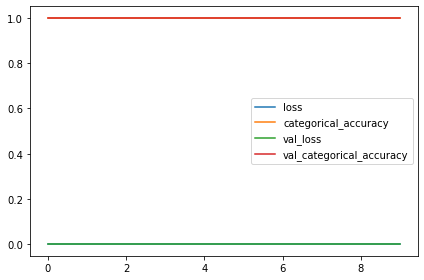

In [40]:
show_history(history_dense_model)

In [45]:
test_gen = DataGenerator(test_x, test_y, batch_size)

# Load best setup
dense_model.load_weights('weights_dense_model.best.hdf5')
pred_y = dense_model.predict(test_gen)

157/157 [==============================] - 1s 5ms/step


In [63]:
# Calculate accuracy on test data
accuracy = calculate_accuracy(pred_y, test_y)
print(f"Accuracy: {round(accuracy, 2) * 100} %")

Accuracy: 100.0 %


### Using Recurrent ANN

In [68]:
# Create checkpoint for storing only best results
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights_recurrent_model.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

batch_size = 128
epochs = 10

train_gen = DataGenerator(train_x, train_y, batch_size)
val_gen = DataGenerator(val_x, val_y, batch_size)


# Fit model.
history_recurrent_model = recurrent_model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[model_checkpoint_callback])

Epoch 1/10
625/625 [==============================] - 35s 56ms/step - loss: 1.1923e-07 - categorical_accuracy: 1.0000 - val_loss: 1.1921e-07 - val_categorical_accuracy: 1.0000
Epoch 2/10
625/625 [==============================] - 35s 56ms/step - loss: 1.1923e-07 - categorical_accuracy: 1.0000 - val_loss: 1.1921e-07 - val_categorical_accuracy: 1.0000
Epoch 3/10
625/625 [==============================] - 34s 54ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000 - val_loss: 1.1921e-07 - val_categorical_accuracy: 1.0000
Epoch 4/10
625/625 [==============================] - 35s 56ms/step - loss: 1.1927e-07 - categorical_accuracy: 1.0000 - val_loss: 1.1921e-07 - val_categorical_accuracy: 1.0000
Epoch 5/10
625/625 [==============================] - 36s 58ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000 - val_loss: 1.1921e-07 - val_categorical_accuracy: 1.0000
Epoch 6/10
625/625 [==============================] - 36s 57ms/step - loss: 1.1921e-07 - categorical_accuracy: 1.0000 - 

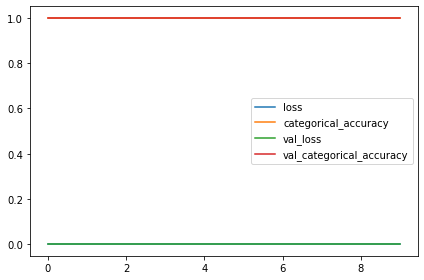

In [69]:
show_history(history_recurrent_model)

In [70]:
test_gen = DataGenerator(test_x, test_y, batch_size)

# Load best setup
recurrent_model.load_weights('weights_recurrent_model.best.hdf5')
pred_y = recurrent_model.predict(test_gen)

157/157 [==============================] - 1s 6ms/step


In [71]:
# Calculate accuracy on test data
accuracy = calculate_accuracy(pred_y, test_y)
print(f"Accuracy: {round(accuracy, 2) * 100} %")

Accuracy: 100.0 %


## Dataset Gene DNA sequences
- Pro trénování je připraven soubou o velikosti 385.21 MB, který se dále v poměru 80:20 rozdělí na trénovací a validační.
- Pro testování je připraven soubor o velikost 0.5 MB
- In my experiments i train ANNs on test data. Because I want to use ANNS to calculate **conditional probabilities** of each byte based on *k* previous bytes in input file. And later use these probabilies as an  input to Arithmetical coding algorithm used for data compression
- In these experiments i train and test ANNs on 0.5 MB of english text on gpus.

In [102]:
# define file that we want to compress
test_filename =  r"./data/dna/test/dna"

In [103]:
# Get original size of file in bits
original_size_in_bits = os.stat(test_filename).st_size * 8
original_size_in_bits

4658528

### Load data

In [104]:
# Load test_x and test_y as bytes from one file
# ANN will train on this test data
test_x, test_y, test_loaded_size = load_data_binary(test_filename, seed=42, lengthOfSubstring=k, portion=1, max_size_in_bytes=5_000_000)
test_x = np.array(test_x)
test_y = np.array(test_y)
print(f"\nSize of test dataset: {len(test_y)} B [{test_loaded_size / 1000 / 1000} MB]")

Loaded bytes [11.6463 %]
Size of test dataset: 582313 B [0.5823160000000001 MB]


In [105]:
# Train dataset is same as test dataset
train_x, train_y = copy.deepcopy(test_x), copy.deepcopy(test_y)

In [106]:
# Load train_x and train_y as bytes
"""
train_filename = r"./data/dna/train/dna"
train_x, train_y, train_loaded_size = load_data_binary(train_filename, seed=42, lengthOfSubstring=k, max_size_in_bytes=5_000_000)
train_x = np.array(train_x)
train_y = np.array(train_y)
print(f"\nSize of train dataset: {len(train_y)} B [{train_loaded_size / 1000 / 1000} MB]")
"""

'\ntrain_filename = r"./data/dna/train/dna"\ntrain_x, train_y, train_loaded_size = load_data_binary(train_filename, seed=42, lengthOfSubstring=k, max_size_in_bytes=5_000_000)\ntrain_x = np.array(train_x)\ntrain_y = np.array(train_y)\nprint(f"\nSize of train dataset: {len(train_y)} B [{train_loaded_size / 1000 / 1000} MB]")\n'

In [107]:
# Split train set into - train and validation set
# WITH shuffle
#train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42, shuffle=True)
# WITHOUT shuffle
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42, shuffle=False)

In [108]:
print(f"Train data: {round(len(train_y) / (len(test_y) + len(train_y) + len(val_y)) * 100, 2) } %")
print(f"Validation data: {round(len(val_y) / (len(test_y) + len(train_y) + len(val_y)) * 100, 2) } %")
print(f"Test data: {round(len(test_y) / (len(test_y) + len(train_y) + len(val_y)) * 100, 2) } %")

Train data: 40.0 %
Validation data: 10.0 %
Test data: 50.0 %


In [109]:
# Size of train, validation and test datasets
print(f"Train set size (X, y): {train_x.shape}, {train_y.shape}")
print(f"Validation set size (X, y): {val_x.shape}, {val_y.shape}")
print(f"Test set size (X, y): {test_x.shape}, {test_y.shape}")

Train set size (X, y): (465850, 3), (465850, 1)
Validation set size (X, y): (116463, 3), (116463, 1)
Test set size (X, y): (582313, 3), (582313, 1)


### Exploratory analysis

In [110]:
# Look at the decoded data. ANNs will work with encoded data. Which are further preprocessed into integer and one hot encoded in the DataGenerator.
df = pd.DataFrame(columns=["X", "y"])
df.X = ["".join([chr(int.from_bytes(_x, byteorder="big")) for _x in x]) for x in train_x]
df.y = ["".join([chr(int.from_bytes(_y, byteorder="big")) for _y in y]) for y in train_y]
df.head(20)

,X,y
0,GAT,C
1,ATC,A
2,TCA,A
3,CAA,T
4,AAT,G
5,ATG,A
6,TGA,G
7,GAG,G
8,AGG,T
9,GGT,G


In [112]:
# How many classes we are going to predict?
# But still my neural networks expects the input size of (Batch Size, k, 256). Because one byte has 256 values.
# And my ANN models are build that way they can work with any data, that can be read by bytes
print(f"Number of classes: {df.y.unique().shape[0]}")
print(f"The classes are: {df.y.unique()}")

Number of classes: 7
The classes are: ['C' 'A' 'T' 'G' '\r' '\n' 'N']


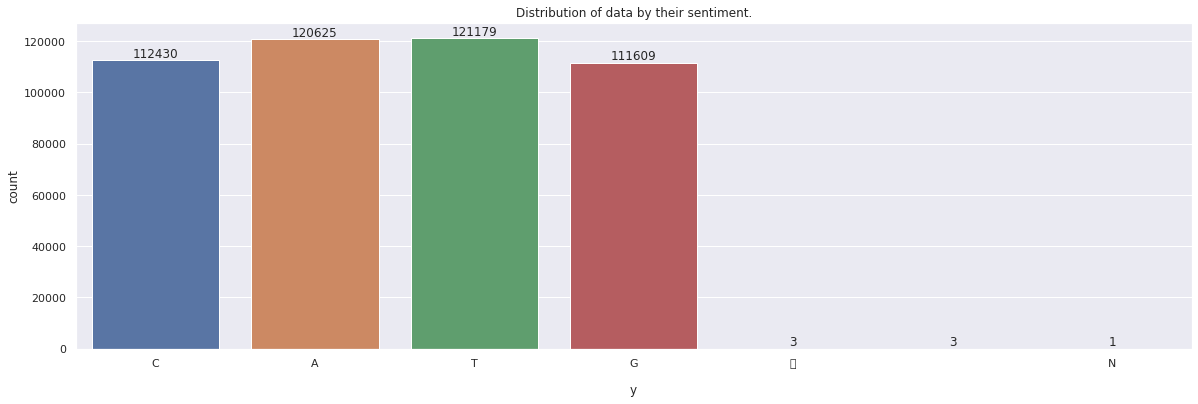

In [113]:
# How are the classes balanced? look at the most frequent byte
fig, ax = plt.subplots(figsize=(20,6))
sns.countplot(data=df, x=df.y, ax=ax)
ax.set_title("Distribution of data by their sentiment.")

for container in ax.containers:
    ax.bar_label(container)
plt.show()

In [114]:
# Take a look at the most frequent k sequence of previous bytes
# Compute frequency of every token 
dist = nltk.FreqDist(df.X.values)

In [115]:
# The most common tokens are
dist

FreqDist({'CTG': 12386, 'AAA': 12075, 'CAG': 12067, 'TTT': 11560, 'TGG': 10836, 'CCA': 10751, 'CCT': 10702, 'AGG': 10166, 'AGA': 10159, 'TCT': 10153, ...})

In [116]:
# Number of unique k sequences of previous bytes in train dataset
len(dist)

71

[]

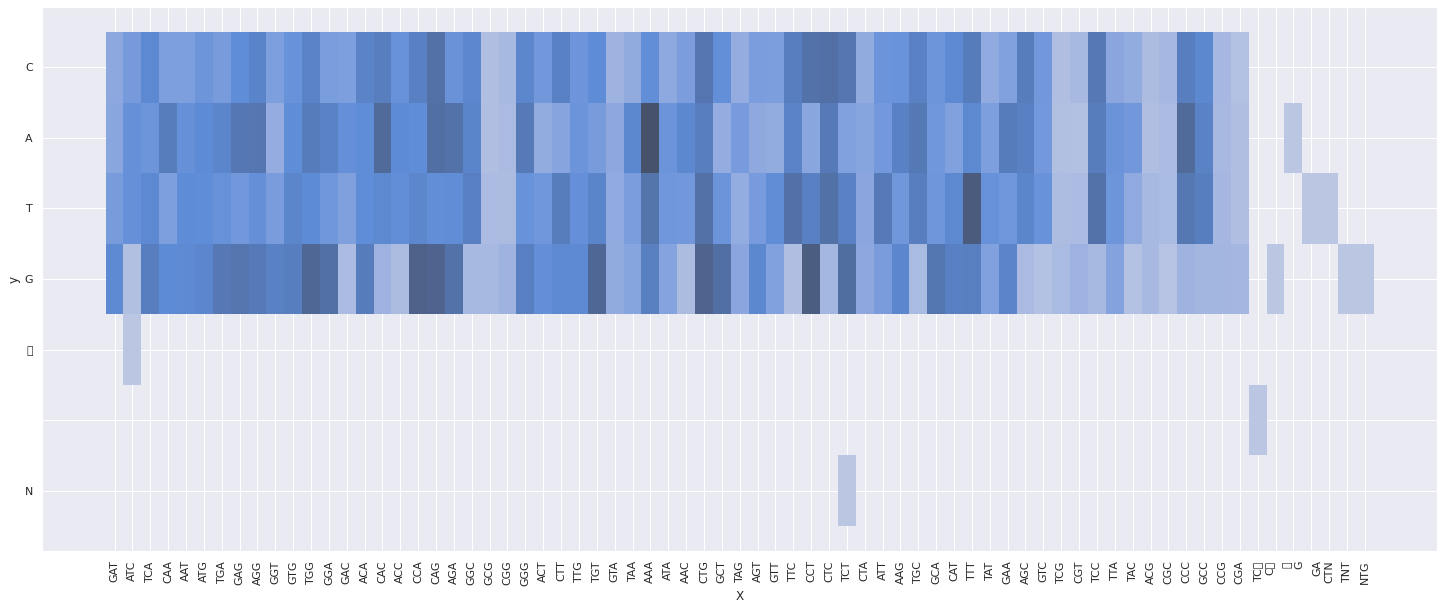

In [117]:
# Look at most frequent combination
fig, ax = plt.subplots(1, 1, figsize=(25,10))
sns.set_theme()
sns.histplot(df, x=df.X, y=df.y, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.plot()

### Compressed size of file using gzip


In [46]:
# run linux gzip and wc commands to get size of compressed file in bytes
gzip_process = subprocess.Popen(['gzip', '-c', test_filename], stdout=subprocess.PIPE, text=True)
wc_process = subprocess.Popen(['wc', '-c'], stdout=subprocess.PIPE, stdin=gzip_process.stdout, text=True)
output, error = wc_process.communicate()

In [47]:
# Check if commands ran succesfuly
compressed_file_size_in_bits = 0
if error is None:
    compressed_file_size_in_bits = int(output) * 8
    print(f"Size of compressed file using gzip in bits: {compressed_file_size_in_bits} b")
else:
    print(f"Command \"gzip -c {test_filename} | wc -c\" failed with error: {error}")
    
# Print compression rate achieved with using gzip
print("Compression ratio: ",calculate_compression_ratio(original_size_in_bits, compressed_file_size_in_bits))
print("Space saving: ", calculate_space_saving(original_size_in_bits, compressed_file_size_in_bits))

Size of compressed file using gzip in bits: 1326368 b
Compression ratio:  3.5122
Space saving:  0.7153


### Calculating Entropy using static frequencies

In [72]:
# Get alphabet of test file
characters = list(set([y[0] for y in test_y]))
len(characters)

7

In [73]:
# Calculate frequencies for each symbol of alphabet
frequency_table = { c:0 for c in characters }
for c in test_y:
    frequency_table[c[0]] += 1

In [74]:
# Calculate probabilities for each symbol of alphabet
probability_table = { c:0 for c in characters}
for c, f in frequency_table.items():
    probability_table[c] = f / len(test_y)

In [75]:
# Calculate avg entropy of whole test file for one character

H = 0
for c, p in probability_table.items():
    H -= (p) * np.log2(p)
print(H)
# Calculate entropy of whole file
H = H * len(test_y)
print(H)


1.9981819639752216
1163567.3339883033


In [76]:
# Calculate entropy of whole file
H = 0
for c in test_y:
    H -= 1 * np.log2(probability_table[c[0]])
H

1163567.3339870996

In [77]:
# Print predicted entropy of file (file size in bits) and original file size [bits]
H, original_size_in_bits

(1163567.3339870996, 4658528)

In [78]:
# Print potential compression rate, i.e. entropy of file
print("Compression ratio: ",calculate_compression_ratio(original_size_in_bits, H))
print("Space saving: ", calculate_space_saving(original_size_in_bits, H))

Compression ratio:  4.0037
Space saving:  0.7502


### Calculating Entropy using dynamic ANN predictions

In [38]:
batch_sizes = [128, 32]

#### Calculating Entropy using Dense ANN predictions

##### Model 0

Epoch 1/10
3640/3640 [==============================] - 32s 9ms/step - loss: 1.3466 - categorical_accuracy: 0.3220 - val_loss: 1.3405 - val_categorical_accuracy: 0.3278
Epoch 2/10
3640/3640 [==============================] - 31s 9ms/step - loss: 1.3364 - categorical_accuracy: 0.3265 - val_loss: 1.3458 - val_categorical_accuracy: 0.3257
Epoch 3/10
3640/3640 [==============================] - 30s 8ms/step - loss: 1.3353 - categorical_accuracy: 0.3288 - val_loss: 1.3369 - val_categorical_accuracy: 0.3314
Epoch 4/10
3640/3640 [==============================] - 31s 8ms/step - loss: 1.3347 - categorical_accuracy: 0.3293 - val_loss: 1.3391 - val_categorical_accuracy: 0.3337
Epoch 5/10
3640/3640 [==============================] - 31s 8ms/step - loss: 1.3347 - categorical_accuracy: 0.3297 - val_loss: 1.3405 - val_categorical_accuracy: 0.3297
Epoch 6/10
3640/3640 [==============================] - 30s 8ms/step - loss: 1.3344 - categorical_accuracy: 0.3300 - val_loss: 1.3375 - val_categorical_acc

INFO:tensorflow:Assets written to: models/dna/dense_00/model/010/assets


4550/4550 [==============================] - 24s 5ms/step
Accuracy: 0.3319
Epoch 1/10
14558/14558 [==============================] - 115s 8ms/step - loss: 1.3409 - categorical_accuracy: 0.3229 - val_loss: 1.3402 - val_categorical_accuracy: 0.3269
Epoch 2/10
14558/14558 [==============================] - 112s 8ms/step - loss: 1.3355 - categorical_accuracy: 0.3289 - val_loss: 1.3396 - val_categorical_accuracy: 0.3274
Epoch 3/10
14558/14558 [==============================] - 114s 8ms/step - loss: 1.3348 - categorical_accuracy: 0.3291 - val_loss: 1.3424 - val_categorical_accuracy: 0.3235
Epoch 4/10
14558/14558 [==============================] - 113s 8ms/step - loss: 1.3346 - categorical_accuracy: 0.3303 - val_loss: 1.3390 - val_categorical_accuracy: 0.3293
Epoch 5/10
14558/14558 [==============================] - 114s 8ms/step - loss: 1.3344 - categorical_accuracy: 0.3304 - val_loss: 1.3391 - val_categorical_accuracy: 0.3307
Epoch 6/10
14558/14558 [==============================] - 113s 8m

INFO:tensorflow:Assets written to: models/dna/dense_00/model/010/assets


18198/18198 [==============================] - 47s 3ms/step
Accuracy: 0.3321


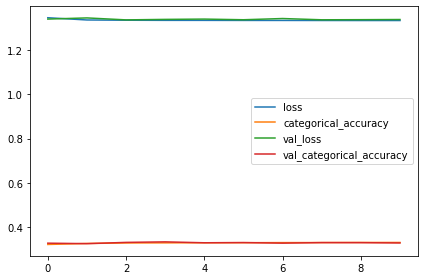

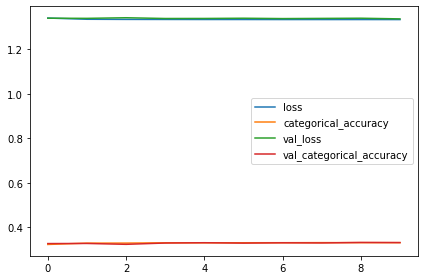

In [179]:
for b_s in batch_sizes:
    model = create_dense_model_0()
    weight_filepath = 'models/dna/dense_00/weights/01.best.hdf5'
    model_filepath = 'models/dna/dense_00/model/010'
    
    experiment(train_x, train_y, val_x, val_y, test_x, test_y, model, weight_filepath, model_filepath, original_size_in_bits, batch_size=b_s,
              epochs=10, shuffle=True, k=k)

##### Model 1

Epoch 1/10
3640/3640 [==============================] - 32s 9ms/step - loss: 1.3548 - categorical_accuracy: 0.3210 - val_loss: 1.3381 - val_categorical_accuracy: 0.3300
Epoch 2/10
3640/3640 [==============================] - 31s 9ms/step - loss: 1.3367 - categorical_accuracy: 0.3256 - val_loss: 1.3392 - val_categorical_accuracy: 0.3267
Epoch 3/10
3640/3640 [==============================] - 30s 8ms/step - loss: 1.3356 - categorical_accuracy: 0.3281 - val_loss: 1.3397 - val_categorical_accuracy: 0.3256
Epoch 4/10
3640/3640 [==============================] - 30s 8ms/step - loss: 1.3348 - categorical_accuracy: 0.3294 - val_loss: 1.3380 - val_categorical_accuracy: 0.3297
Epoch 5/10
3640/3640 [==============================] - 29s 8ms/step - loss: 1.3346 - categorical_accuracy: 0.3287 - val_loss: 1.3379 - val_categorical_accuracy: 0.3301
Epoch 6/10
3640/3640 [==============================] - 31s 8ms/step - loss: 1.3345 - categorical_accuracy: 0.3300 - val_loss: 1.3383 - val_categorical_acc

INFO:tensorflow:Assets written to: models/dna/dense_01/model/01/assets


4550/4550 [==============================] - 19s 4ms/step
Accuracy: 0.3316
Epoch 1/10
14558/14558 [==============================] - 103s 7ms/step - loss: 1.3426 - categorical_accuracy: 0.3239 - val_loss: 1.3375 - val_categorical_accuracy: 0.3322
Epoch 2/10
14558/14558 [==============================] - 102s 7ms/step - loss: 1.3353 - categorical_accuracy: 0.3281 - val_loss: 1.3377 - val_categorical_accuracy: 0.3316
Epoch 3/10
14558/14558 [==============================] - 100s 7ms/step - loss: 1.3348 - categorical_accuracy: 0.3291 - val_loss: 1.3423 - val_categorical_accuracy: 0.3228
Epoch 4/10
14558/14558 [==============================] - 101s 7ms/step - loss: 1.3345 - categorical_accuracy: 0.3295 - val_loss: 1.3369 - val_categorical_accuracy: 0.3312
Epoch 5/10
14558/14558 [==============================] - 102s 7ms/step - loss: 1.3344 - categorical_accuracy: 0.3300 - val_loss: 1.3385 - val_categorical_accuracy: 0.3304
Epoch 6/10
14558/14558 [==============================] - 102s 7m

INFO:tensorflow:Assets written to: models/dna/dense_01/model/01/assets


18198/18198 [==============================] - 44s 2ms/step
Accuracy: 0.3319


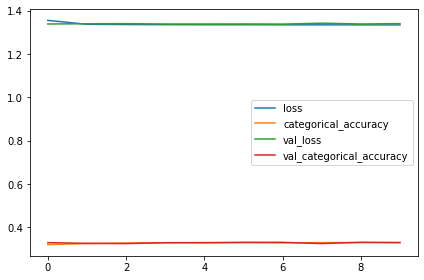

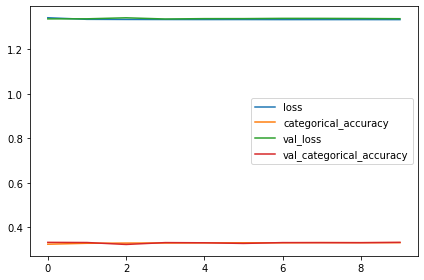

In [180]:
for b_s in batch_sizes:
    model = create_dense_model_1()
    weight_filepath = 'models/dna/dense_01/weights/01.best.hdf5'
    model_filepath = 'models/dna/dense_01/model/01'
    
    experiment(train_x, train_y, val_x, val_y, test_x, test_y, model, weight_filepath, model_filepath, original_size_in_bits, batch_size=b_s,
              epochs=10, shuffle=True, k=k)

##### Model 2

Epoch 1/10
3640/3640 [==============================] - 30s 8ms/step - loss: 1.3619 - categorical_accuracy: 0.3195 - val_loss: 1.3407 - val_categorical_accuracy: 0.3237
Epoch 2/10
3640/3640 [==============================] - 28s 8ms/step - loss: 1.3378 - categorical_accuracy: 0.3242 - val_loss: 1.3387 - val_categorical_accuracy: 0.3292
Epoch 3/10
3640/3640 [==============================] - 29s 8ms/step - loss: 1.3375 - categorical_accuracy: 0.3246 - val_loss: 1.3452 - val_categorical_accuracy: 0.3229
Epoch 4/10
3640/3640 [==============================] - 29s 8ms/step - loss: 1.3369 - categorical_accuracy: 0.3248 - val_loss: 1.3433 - val_categorical_accuracy: 0.3210
Epoch 5/10
3640/3640 [==============================] - 28s 8ms/step - loss: 1.3361 - categorical_accuracy: 0.3259 - val_loss: 1.3401 - val_categorical_accuracy: 0.3276
Epoch 6/10
3640/3640 [==============================] - 29s 8ms/step - loss: 1.3356 - categorical_accuracy: 0.3273 - val_loss: 1.3376 - val_categorical_acc

INFO:tensorflow:Assets written to: models/dna/dense_02/model/01/assets


4550/4550 [==============================] - 19s 4ms/step
Accuracy: 0.3311
Epoch 1/10
14558/14558 [==============================] - 100s 7ms/step - loss: 1.3455 - categorical_accuracy: 0.3213 - val_loss: 1.3408 - val_categorical_accuracy: 0.3238
Epoch 2/10
14558/14558 [==============================] - 97s 7ms/step - loss: 1.3366 - categorical_accuracy: 0.3258 - val_loss: 1.3395 - val_categorical_accuracy: 0.3258
Epoch 3/10
14558/14558 [==============================] - 96s 7ms/step - loss: 1.3352 - categorical_accuracy: 0.3283 - val_loss: 1.3389 - val_categorical_accuracy: 0.3311
Epoch 4/10
14558/14558 [==============================] - 98s 7ms/step - loss: 1.3349 - categorical_accuracy: 0.3282 - val_loss: 1.3380 - val_categorical_accuracy: 0.3304
Epoch 5/10
14558/14558 [==============================] - 98s 7ms/step - loss: 1.3346 - categorical_accuracy: 0.3289 - val_loss: 1.3402 - val_categorical_accuracy: 0.3258
Epoch 6/10
14558/14558 [==============================] - 98s 7ms/ste

INFO:tensorflow:Assets written to: models/dna/dense_02/model/01/assets


18198/18198 [==============================] - 43s 2ms/step
Accuracy: 0.3316


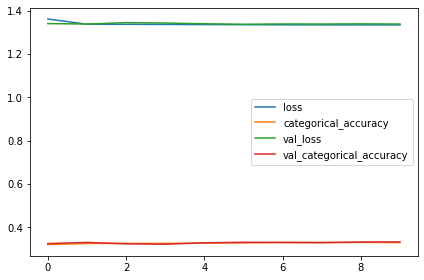

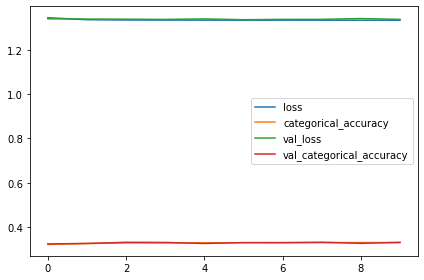

In [181]:
for b_s in batch_sizes:
    model = create_dense_model_2()
    weight_filepath = 'models/dna/dense_02/weights/01.best.hdf5'
    model_filepath = 'models/dna/dense_02/model/01'
    
    experiment(train_x, train_y, val_x, val_y, test_x, test_y, model, weight_filepath, model_filepath, original_size_in_bits, batch_size=b_s,
              epochs=10, shuffle=True, k=k)

#### Calculating Entropy using Recurrent ANN predictions

##### Model 0

Epoch 1/5
14558/14558 [==============================] - 1163s 80ms/step - loss: 1.3440 - categorical_accuracy: 0.3202 - val_loss: 1.3384 - val_categorical_accuracy: 0.3260
Epoch 2/5
14558/14558 [==============================] - 1146s 79ms/step - loss: 1.3389 - categorical_accuracy: 0.3252 - val_loss: 1.3429 - val_categorical_accuracy: 0.3198
Epoch 3/5
14558/14558 [==============================] - 1314s 90ms/step - loss: 1.3384 - categorical_accuracy: 0.3257 - val_loss: 1.3409 - val_categorical_accuracy: 0.3278
Epoch 4/5
14558/14558 [==============================] - 1395s 96ms/step - loss: 1.3382 - categorical_accuracy: 0.3247 - val_loss: 1.3415 - val_categorical_accuracy: 0.3261
Epoch 5/5
14558/14558 [==============================] - 1265s 87ms/step - loss: 1.3385 - categorical_accuracy: 0.3247 - val_loss: 1.3431 - val_categorical_accuracy: 0.3240
INFO:tensorflow:Assets written to: models/dna/recurrent_00//model/01/assets
18198/18198 [==============================] - 181s 10ms/st

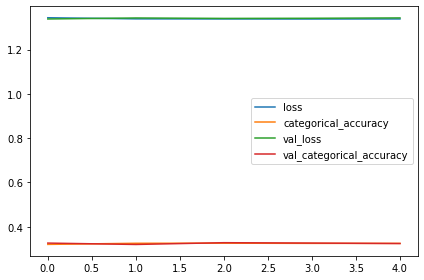

In [37]:
for b_s in batch_sizes:
    model = create_recurrent_model_0()
    weight_filepath = 'models/dna/recurrent_00/weights/01.best.hdf5'
    model_filepath = 'models/dna/recurrent_00//model/01'
    
    experiment(train_x, train_y, val_x, val_y, test_x, test_y, model, weight_filepath, model_filepath, original_size_in_bits, batch_size=b_s,
              epochs=5, shuffle=True, k=k)

##### Model 1

Epoch 1/5
3640/3640 [==============================] - 73s 19ms/step - loss: 1.3764 - categorical_accuracy: 0.3112 - val_loss: 1.3394 - val_categorical_accuracy: 0.3311
Epoch 2/5
3640/3640 [==============================] - 72s 20ms/step - loss: 1.3358 - categorical_accuracy: 0.3277 - val_loss: 1.3402 - val_categorical_accuracy: 0.3302
Epoch 3/5
3640/3640 [==============================] - 70s 19ms/step - loss: 1.3354 - categorical_accuracy: 0.3285 - val_loss: 1.3399 - val_categorical_accuracy: 0.3296
Epoch 4/5
3640/3640 [==============================] - 75s 20ms/step - loss: 1.3353 - categorical_accuracy: 0.3287 - val_loss: 1.3420 - val_categorical_accuracy: 0.3302
Epoch 5/5
3640/3640 [==============================] - 72s 20ms/step - loss: 1.3351 - categorical_accuracy: 0.3295 - val_loss: 1.3419 - val_categorical_accuracy: 0.3298


INFO:tensorflow:Assets written to: models/dna/recurrent_01//model/01/assets


INFO:tensorflow:Assets written to: models/dna/recurrent_01//model/01/assets


4550/4550 [==============================] - 27s 6ms/step
Accuracy: 0.3306
Epoch 1/5
14558/14558 [==============================] - 273s 19ms/step - loss: 1.3496 - categorical_accuracy: 0.3195 - val_loss: 1.3472 - val_categorical_accuracy: 0.3206
Epoch 2/5
14558/14558 [==============================] - 230s 16ms/step - loss: 1.3374 - categorical_accuracy: 0.3262 - val_loss: 1.3410 - val_categorical_accuracy: 0.3271
Epoch 3/5
14558/14558 [==============================] - 237s 16ms/step - loss: 1.3373 - categorical_accuracy: 0.3259 - val_loss: 1.3416 - val_categorical_accuracy: 0.3226
Epoch 4/5
14558/14558 [==============================] - 271s 19ms/step - loss: 1.3375 - categorical_accuracy: 0.3256 - val_loss: 1.3371 - val_categorical_accuracy: 0.3311
Epoch 5/5
14558/14558 [==============================] - 269s 18ms/step - loss: 1.3372 - categorical_accuracy: 0.3264 - val_loss: 1.3453 - val_categorical_accuracy: 0.3097


INFO:tensorflow:Assets written to: models/dna/recurrent_01//model/01/assets


INFO:tensorflow:Assets written to: models/dna/recurrent_01//model/01/assets


18198/18198 [==============================] - 87s 5ms/step
Accuracy: 0.3169


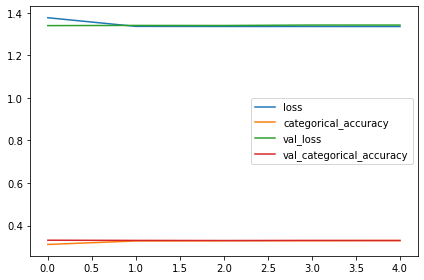

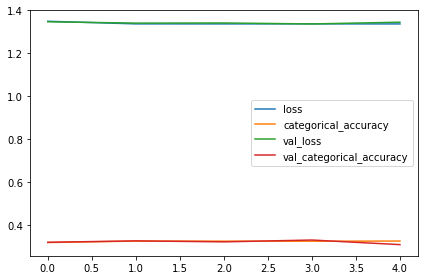

In [39]:
for b_s in batch_sizes:
    model = create_recurrent_model_1()
    weight_filepath = 'models/dna/recurrent_01/weights/01.best.hdf5'
    model_filepath = 'models/dna/recurrent_01//model/01'
    
    experiment(train_x, train_y, val_x, val_y, test_x, test_y, model, weight_filepath, model_filepath, original_size_in_bits, batch_size=b_s,
              epochs=5, shuffle=True, k=k)

##### Model 2

Epoch 1/5
3640/3640 [==============================] - 111s 30ms/step - loss: 1.3979 - categorical_accuracy: 0.3129 - val_loss: 1.3381 - val_categorical_accuracy: 0.3284
Epoch 2/5
3640/3640 [==============================] - 112s 31ms/step - loss: 1.3367 - categorical_accuracy: 0.3252 - val_loss: 1.3415 - val_categorical_accuracy: 0.3263
Epoch 3/5
3640/3640 [==============================] - 109s 30ms/step - loss: 1.3357 - categorical_accuracy: 0.3279 - val_loss: 1.3376 - val_categorical_accuracy: 0.3255
Epoch 4/5
3640/3640 [==============================] - 107s 29ms/step - loss: 1.3353 - categorical_accuracy: 0.3280 - val_loss: 1.3427 - val_categorical_accuracy: 0.3261
Epoch 5/5
3640/3640 [==============================] - 111s 30ms/step - loss: 1.3350 - categorical_accuracy: 0.3293 - val_loss: 1.3421 - val_categorical_accuracy: 0.3266
INFO:tensorflow:Assets written to: models/dna/recurrent_02//model/01/assets


INFO:tensorflow:Assets written to: models/dna/recurrent_02//model/01/assets


4550/4550 [==============================] - 25s 5ms/step
Accuracy: 0.3277


Epoch 1/5
14558/14558 [==============================] - 401s 27ms/step - loss: 1.3568 - categorical_accuracy: 0.3201 - val_loss: 1.3426 - val_categorical_accuracy: 0.3244
Epoch 2/5
14558/14558 [==============================] - 387s 27ms/step - loss: 1.3366 - categorical_accuracy: 0.3271 - val_loss: 1.3409 - val_categorical_accuracy: 0.3263
Epoch 3/5
14558/14558 [==============================] - 386s 27ms/step - loss: 1.3364 - categorical_accuracy: 0.3272 - val_loss: 1.3426 - val_categorical_accuracy: 0.3259
Epoch 4/5
14558/14558 [==============================] - 384s 26ms/step - loss: 1.3365 - categorical_accuracy: 0.3265 - val_loss: 1.3392 - val_categorical_accuracy: 0.3291
Epoch 5/5
14558/14558 [==============================] - 382s 26ms/step - loss: 1.3364 - categorical_accuracy: 0.3268 - val_loss: 1.3426 - val_categorical_accuracy: 0.3289
INFO:tensorflow:Assets written to: models/dna/recurrent_02//model/01/assets


INFO:tensorflow:Assets written to: models/dna/recurrent_02//model/01/assets


18198/18198 [==============================] - 74s 4ms/step
Accuracy: 0.3293


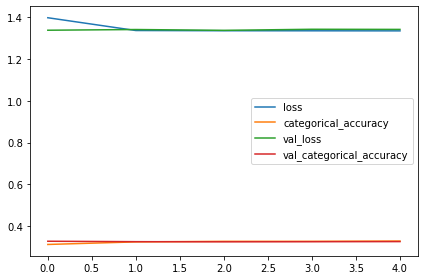

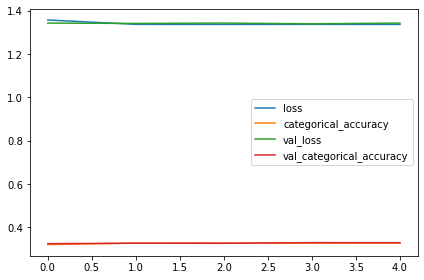

In [40]:
for b_s in batch_sizes:
    model = create_recurrent_model_2()
    weight_filepath = 'models/dna/recurrent_02/weights/01.best.hdf5'
    model_filepath = 'models/dna/recurrent_02//model/01'
    
    experiment(train_x, train_y, val_x, val_y, test_x, test_y, model, weight_filepath, model_filepath, original_size_in_bits, batch_size=b_s,
              epochs=5, shuffle=True, k=k)

##### Model 3

Epoch 1/5
3640/3640 [==============================] - 86s 23ms/step - loss: 1.4564 - categorical_accuracy: 0.3044 - val_loss: 1.3434 - val_categorical_accuracy: 0.3216
Epoch 2/5
3640/3640 [==============================] - 85s 23ms/step - loss: 1.3387 - categorical_accuracy: 0.3236 - val_loss: 1.3400 - val_categorical_accuracy: 0.3257
Epoch 3/5
3640/3640 [==============================] - 85s 23ms/step - loss: 1.3373 - categorical_accuracy: 0.3255 - val_loss: 1.3379 - val_categorical_accuracy: 0.3301
Epoch 4/5
3640/3640 [==============================] - 85s 23ms/step - loss: 1.3365 - categorical_accuracy: 0.3259 - val_loss: 1.3418 - val_categorical_accuracy: 0.3249
Epoch 5/5
3640/3640 [==============================] - 86s 24ms/step - loss: 1.3360 - categorical_accuracy: 0.3258 - val_loss: 1.3404 - val_categorical_accuracy: 0.3276
INFO:tensorflow:Assets written to: models/dna/recurrent_03//model/01/assets


INFO:tensorflow:Assets written to: models/dna/recurrent_03//model/01/assets


4550/4550 [==============================] - 24s 5ms/step
Accuracy: 0.3284


Epoch 1/5
14558/14558 [==============================] - 331s 23ms/step - loss: 1.3742 - categorical_accuracy: 0.3142 - val_loss: 1.3441 - val_categorical_accuracy: 0.3196
Epoch 2/5
14558/14558 [==============================] - 322s 22ms/step - loss: 1.3373 - categorical_accuracy: 0.3248 - val_loss: 1.3422 - val_categorical_accuracy: 0.3211
Epoch 3/5
14558/14558 [==============================] - 309s 21ms/step - loss: 1.3368 - categorical_accuracy: 0.3264 - val_loss: 1.3401 - val_categorical_accuracy: 0.3254
Epoch 4/5
14558/14558 [==============================] - 329s 23ms/step - loss: 1.3368 - categorical_accuracy: 0.3266 - val_loss: 1.3413 - val_categorical_accuracy: 0.3259
Epoch 5/5
14558/14558 [==============================] - 335s 23ms/step - loss: 1.3369 - categorical_accuracy: 0.3266 - val_loss: 1.3409 - val_categorical_accuracy: 0.3265
INFO:tensorflow:Assets written to: models/dna/recurrent_03//model/01/assets


INFO:tensorflow:Assets written to: models/dna/recurrent_03//model/01/assets


18198/18198 [==============================] - 74s 4ms/step
Accuracy: 0.3288


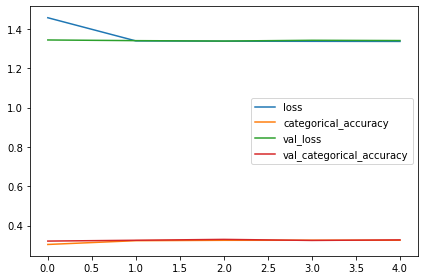

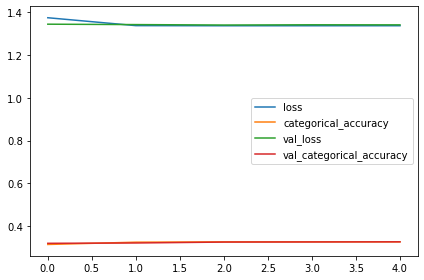

In [41]:
for b_s in batch_sizes:
    model = create_recurrent_model_3()
    weight_filepath = 'models/dna/recurrent_03/weights/01.best.hdf5'
    model_filepath = 'models/dna/recurrent_03//model/01'
    
    experiment(train_x, train_y, val_x, val_y, test_x, test_y, model, weight_filepath, model_filepath, original_size_in_bits, batch_size=b_s,
              epochs=5, shuffle=True, k=k)

### Calculating Entropy using dynamic ANN predictions, transfer learning

#### Using Dense ANN

##### Model 0

In [200]:
# Load trained model and weights
dense_model_01 = tf.keras.models.load_model(r"models/model_dense_01_00")

In [201]:
# Freeze the base model
dense_model_01.trainable = False

In [202]:
# Transfer learning
inputs = tf.keras.Input(shape=inputShape_english)

dense_layer = dense_model_01(inputs, training=False)

outputs = tf.keras.layers.Dense(alphabetSize_dna, activation="softmax")(dense_layer)
outputs = tf.keras.layers.Reshape(outputShape_dna)(outputs)

dense_model_dna_01 = tf.keras.Model(inputs, outputs)

In [203]:
# Compile model
# Optimizer - RMSprop
# Loss - Categorical Crossentropy
# Metric - Categorical Accuracy
dense_model_dna_01.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001 , beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False),
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [204]:
# Create checkpoint for storing only best results
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='models/weights/weights_dense_model_dna_01_00.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

batch_size = 1024
epochs = 10

train_gen = DataGenerator(train_x, train_y, batch_size, x_num_classes=alphabetSize_english, y_num_classes=alphabetSize_dna,
                          x_alphabet=english_map, y_alphabet=dna_map)
val_gen = DataGenerator(val_x, val_y, batch_size, x_num_classes=alphabetSize_english, y_num_classes=alphabetSize_dna,
                          x_alphabet=english_map, y_alphabet=dna_map)

# Shuffle train data at start of each epoch
# Fit model.
history_dense_model = dense_model_dna_01.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[model_checkpoint_callback], shuffle=True)

Epoch 1/10
4883/4883 [==============================] - 450s 92ms/step - loss: 1.4221 - categorical_accuracy: 0.2898 - val_loss: 1.3809 - val_categorical_accuracy: 0.2932
Epoch 2/10
4883/4883 [==============================] - 457s 94ms/step - loss: 1.3782 - categorical_accuracy: 0.2924 - val_loss: 1.3769 - val_categorical_accuracy: 0.2936
Epoch 3/10
4883/4883 [==============================] - 469s 96ms/step - loss: 1.3768 - categorical_accuracy: 0.2923 - val_loss: 1.3766 - val_categorical_accuracy: 0.2932
Epoch 4/10
4883/4883 [==============================] - 462s 95ms/step - loss: 1.3767 - categorical_accuracy: 0.2922 - val_loss: 1.3764 - val_categorical_accuracy: 0.2937
Epoch 5/10
4883/4883 [==============================] - 457s 94ms/step - loss: 1.3767 - categorical_accuracy: 0.2923 - val_loss: 1.3766 - val_categorical_accuracy: 0.2936
Epoch 6/10
4883/4883 [==============================] - 448s 92ms/step - loss: 1.3767 - categorical_accuracy: 0.2923 - val_loss: 1.3763 - val_cat

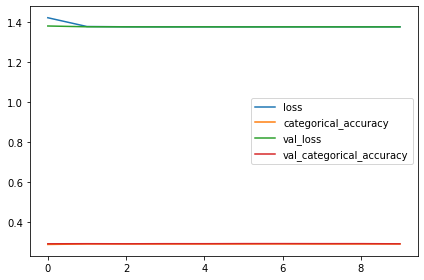

In [205]:
show_history(history_dense_model)

In [206]:
# Save trained weights and biases.
dense_model_dna_01.save('models/model_dense_dna_01_00')

INFO:tensorflow:Assets written to: models/model_dense_dna_01_00/assets


In [207]:
# Make predictions on data
batch_size = 1024
test_gen = DataGenerator(test_x, test_y, batch_size)

# Load best setup
dense_model_dna_01.load_weights('models/weights/weights_dense_model_dna_01_00.best.hdf5')
pred_y = dense_model_dna_01.predict(test_gen)

569/569 [==============================] - 62s 108ms/step


In [208]:
# Calculate predicted size of file after compresion using predicted probabilities
predicted_size_in_bits = 0
for prediction in pred_y:
    highest_probability = np.max(prediction[0])
    #print(highest_probability, predicted_size_in_bits)
    predicted_size_in_bits -= 1 * (np.log2(highest_probability))


In [236]:
# Print predicted compressed file size and original not compressed file size
predicted_size_in_bits, original_size_in_bits

(1037960.7024649084, 4658016)

In [237]:
# Print compression rate
print((1 - (predicted_size_in_bits / original_size_in_bits)) * 100, "%")

77.71667803492069 %


In [232]:
# Calculate accuracy on test data
accuracy = calculate_accuracy(pred_y, test_y, alphabet_size=alphabetSize_dna, alphabet_map = inverse_dna_map)
print(f"Accuracy: {round(accuracy * 100, 2)} %")

Accuracy: 28.27 %


##### Model 2

In [316]:
# Load trained model and weights
dense_model_02 = tf.keras.models.load_model(r"models/model_dense_02_02")

In [317]:
# Freeze the base model
dense_model_02.trainable = False

In [318]:
# Transfer learning
inputs = tf.keras.Input(shape=inputShape_english)

dense_layer = dense_model_02(inputs, training=False)

outputs = tf.keras.layers.Dense(alphabetSize_dna, activation="softmax")(dense_layer)
outputs = tf.keras.layers.Reshape(outputShape_dna)(outputs)

dense_model_dna_02 = tf.keras.Model(inputs, outputs)

In [319]:
# Compile model
# Optimizer - RMSprop
# Loss - Categorical Crossentropy
# Metric - Categorical Accuracy
dense_model_dna_02.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001 , beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False),
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [320]:
# Create checkpoint for storing only best results
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='models/weights/weights_dense_model_dna_02_02.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

batch_size = 1024
epochs = 10

train_gen = DataGenerator(train_x, train_y, batch_size, x_num_classes=alphabetSize_english, y_num_classes=alphabetSize_dna,
                          x_alphabet=english_map, y_alphabet=dna_map)
val_gen = DataGenerator(val_x, val_y, batch_size, x_num_classes=alphabetSize_english, y_num_classes=alphabetSize_dna,
                          x_alphabet=english_map, y_alphabet=dna_map)

# Shuffle train data at start of each epoch
# Fit model.
history = dense_model_dna_02.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[model_checkpoint_callback], shuffle=True)

Epoch 1/10
4883/4883 [==============================] - 459s 94ms/step - loss: 1.4376 - categorical_accuracy: 0.2929 - val_loss: 1.3802 - val_categorical_accuracy: 0.2990
Epoch 2/10
4883/4883 [==============================] - 449s 92ms/step - loss: 1.3769 - categorical_accuracy: 0.2968 - val_loss: 1.3754 - val_categorical_accuracy: 0.2992
Epoch 3/10
4883/4883 [==============================] - 488s 100ms/step - loss: 1.3750 - categorical_accuracy: 0.2969 - val_loss: 1.3749 - val_categorical_accuracy: 0.2988
Epoch 4/10
4883/4883 [==============================] - 462s 95ms/step - loss: 1.3748 - categorical_accuracy: 0.2968 - val_loss: 1.3748 - val_categorical_accuracy: 0.2991
Epoch 5/10
4883/4883 [==============================] - 472s 97ms/step - loss: 1.3748 - categorical_accuracy: 0.2967 - val_loss: 1.3751 - val_categorical_accuracy: 0.2990
Epoch 6/10
4883/4883 [==============================] - 478s 98ms/step - loss: 1.3748 - categorical_accuracy: 0.2968 - val_loss: 1.3747 - val_ca

In [321]:
# Save trained weights and biases.
dense_model_dna_02.save('models/model_dense_dna_02_02')

INFO:tensorflow:Assets written to: models/model_dense_dna_02_02/assets


INFO:tensorflow:Assets written to: models/model_dense_dna_02_02/assets


In [322]:
# Make predictions on data
batch_size = 1024
test_gen = DataGenerator(test_x, test_y, batch_size)

# Load best setup
dense_model_dna_02.load_weights('models/weights/weights_dense_model_dna_02_02.best.hdf5')
pred_y = dense_model_dna_02.predict(test_gen)

569/569 [==============================] - 62s 107ms/step


In [306]:
# Calculate predicted size of file after compresion using predicted probabilities
predicted_size_in_bits = 0
for i, prediction in enumerate(pred_y):
    #expected_probability = prediction[0][dna_map[test_y[i][0]]]
    highest_probability = np.max(prediction[0])
    predicted_size_in_bits -= 1 * (np.log2(highest_probability))

# Print predicted compressed file size and original not compressed file size
print(predicted_size_in_bits, original_size_in_bits)
# Print compression rate
print((1 - (predicted_size_in_bits / original_size_in_bits)) * 100, "%")

1027175.0685872436 4658016
77.94822798832715 %


In [309]:
# Calculate accuracy on test data
accuracy = calculate_accuracy(pred_y, test_y, alphabet_size=alphabetSize_dna, alphabet_map = inverse_dna_map)
print(f"Accuracy: {round(accuracy * 100, 2)} %")

Accuracy: 28.95 %


#### Using Recurrent ANN

##### Model 1

In [244]:
# Load trained model and weights
recurrent_model_01 = tf.keras.models.load_model(r"models/model_recurrent_01_00")

In [245]:
# Freeze the base model
recurrent_model_01.trainable = False

In [246]:
# Transfer learning
inputs = tf.keras.Input(shape=inputShape_english)

dense_layer = recurrent_model_01(inputs, training=False)

outputs = tf.keras.layers.Dense(alphabetSize_dna, activation="softmax")(dense_layer)
outputs = tf.keras.layers.Reshape(outputShape_dna)(outputs)

recurrent_model_dna_01 = tf.keras.Model(inputs, outputs)

In [247]:
# Compile model
# Optimizer - RMSprop
# Loss - Categorical Crossentropy
# Metric - Categorical Accuracy
recurrent_model_dna_01.compile(optimizer=tf.keras.optimizers.RMSprop(),
                                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                                metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [249]:
# Create checkpoint for storing only best results
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='models/weights/weights_recurrent_model_dna_01_00.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

batch_size = 2048
epochs = 1

train_gen = DataGenerator(train_x, train_y, batch_size, x_num_classes=alphabetSize_english, y_num_classes=alphabetSize_dna,
                          x_alphabet=english_map, y_alphabet=dna_map)
val_gen = DataGenerator(val_x, val_y, batch_size, x_num_classes=alphabetSize_english, y_num_classes=alphabetSize_dna,
                          x_alphabet=english_map, y_alphabet=dna_map)

# Shuffle train data at start of each epoch
# Fit model.
history = recurrent_model_dna_01.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[model_checkpoint_callback], shuffle=False)

2442/2442 [==============================] - 2382s 975ms/step - loss: 1.3681 - categorical_accuracy: 0.2993 - val_loss: 1.3789 - val_categorical_accuracy: 0.2881


In [250]:
# Save trained weights and biases.
recurrent_model_dna_01.save('models/model_recurrent_dna_01_00')

INFO:tensorflow:Assets written to: models/model_recurrent_dna_01_00/assets


In [251]:
# Make predictions on data
batch_size = 2048
test_gen = DataGenerator(test_x, test_y, batch_size)

# Load best setup
recurrent_model_dna_01.load_weights('models/weights/weights_recurrent_model_dna_01_00.best.hdf5')
pred_y = recurrent_model_dna_01.predict(test_gen)

285/285 [==============================] - 76s 265ms/step


In [253]:
# Calculate predicted size of file after compresion using predicted probabilities
predicted_size_in_bits = 0
for prediction in pred_y:
    highest_probability = np.max(prediction[0])
    predicted_size_in_bits -= 1 * (np.log2(highest_probability))

# Print predicted compressed file size and original not compressed file size
print(predicted_size_in_bits, original_size_in_bits)
# Print compression rate
print((1 - (predicted_size_in_bits / original_size_in_bits)) * 100, "%")

965319.8185859323 4658016
79.27615923633726 %


In [252]:
# Calculate accuracy on test data
accuracy = calculate_accuracy(pred_y, test_y, alphabet_size=alphabetSize_dna, alphabet_map = inverse_dna_map)
print(f"Accuracy: {round(accuracy * 100, 2)} %")

Accuracy: 27.79 %


##### Model 2

In [254]:
# Load trained model and weights
recurrent_model_02 = tf.keras.models.load_model(r"models/model_recurrent_02_00")

In [255]:
# Freeze the base model
recurrent_model_02.trainable = False

In [256]:
# Transfer learning
inputs = tf.keras.Input(shape=inputShape_english)

dense_layer = recurrent_model_02(inputs, training=False)

outputs = tf.keras.layers.Dense(alphabetSize_dna, activation="softmax")(dense_layer)
outputs = tf.keras.layers.Reshape(outputShape_dna)(outputs)

recurrent_model_dna_02 = tf.keras.Model(inputs, outputs)

In [257]:
# Compile model
# Optimizer - RMSprop
# Loss - Categorical Crossentropy
# Metric - Categorical Accuracy
recurrent_model_dna_02.compile(optimizer=tf.keras.optimizers.RMSprop(),
                                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                                metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [258]:
# Create checkpoint for storing only best results
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='models/weights/weights_recurrent_model_dna_02_00.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

batch_size = 2048
epochs = 5

train_gen = DataGenerator(train_x, train_y, batch_size, x_num_classes=alphabetSize_english, y_num_classes=alphabetSize_dna,
                          x_alphabet=english_map, y_alphabet=dna_map)
val_gen = DataGenerator(val_x, val_y, batch_size, x_num_classes=alphabetSize_english, y_num_classes=alphabetSize_dna,
                          x_alphabet=english_map, y_alphabet=dna_map)

# Shuffle train data at start of each epoch
# Fit model.
history = recurrent_model_dna_02.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[model_checkpoint_callback], shuffle=False)

Epoch 1/5
2442/2442 [==============================] - 539s 218ms/step - loss: 1.4247 - categorical_accuracy: 0.3054 - val_loss: 1.3715 - val_categorical_accuracy: 0.3043
Epoch 2/5
2442/2442 [==============================] - 487s 199ms/step - loss: 1.3592 - categorical_accuracy: 0.3148 - val_loss: 1.3672 - val_categorical_accuracy: 0.3065
Epoch 3/5
2442/2442 [==============================] - 449s 184ms/step - loss: 1.3572 - categorical_accuracy: 0.3162 - val_loss: 1.3659 - val_categorical_accuracy: 0.3077
Epoch 4/5
2442/2442 [==============================] - 462s 189ms/step - loss: 1.3564 - categorical_accuracy: 0.3170 - val_loss: 1.3652 - val_categorical_accuracy: 0.3087
Epoch 5/5
2442/2442 [==============================] - 462s 189ms/step - loss: 1.3559 - categorical_accuracy: 0.3175 - val_loss: 1.3647 - val_categorical_accuracy: 0.3092


In [259]:
# Save trained weights and biases.
recurrent_model_dna_02.save('models/model_recurrent_dna_02_00')

INFO:tensorflow:Assets written to: models/model_recurrent_dna_02_00/assets


INFO:tensorflow:Assets written to: models/model_recurrent_dna_02_00/assets


In [260]:
# Make predictions on data
batch_size = 2048
test_gen = DataGenerator(test_x, test_y, batch_size)

# Load best setup
recurrent_model_dna_02.load_weights('models/weights/weights_recurrent_model_dna_02_00.best.hdf5')
pred_y = recurrent_model_dna_02.predict(test_gen)

285/285 [==============================] - 101s 340ms/step


In [262]:
# Calculate predicted size of file after compresion using predicted probabilities
predicted_size_in_bits = 0
for prediction in pred_y:
    highest_probability = np.max(prediction[0])
    predicted_size_in_bits -= 1 * (np.log2(highest_probability))

# Print predicted compressed file size and original not compressed file size
print(predicted_size_in_bits, original_size_in_bits)
# Print compression rate
print((1 - (predicted_size_in_bits / original_size_in_bits)) * 100, "%")

940426.3732415736 4658016
79.81058087302462 %


In [261]:
# Calculate accuracy on test data
accuracy = calculate_accuracy(pred_y, test_y, alphabet_size=alphabetSize_dna, alphabet_map = inverse_dna_map)
print(f"Accuracy: {round(accuracy * 100, 2)} %")

Accuracy: 29.45 %


## Dataset Gutenberg
- The data consists of 89 text files that together form a set of books.
- I divided these 89 files in a ratio of 80 : 20 into training and test sets.
- In my experiments i train ANNs on test data. Because I want to use ANNS to calculate **conditional probabilities** of each byte based on *k* previous bytes in input file. And later use these probabilies as an  input to Arithmetical coding algorithm used for data compression
- In these experiments i train and test ANNs on 0.5 MB of english text on gpus.

In [34]:
# define file that we want to compress
test_filename = r"./data/gutenberg/test/47-0.txt"

In [35]:
# Get original size of file in bits
original_size_in_bits = os.stat(test_filename).st_size * 8
original_size_in_bits

4255048

### Load data for specific model

In [36]:
# Load test_x and test_y as bytes from one file
# ANN will train on this test data
test_x, test_y, test_loaded_size = load_data_binary(test_filename, seed=42, lengthOfSubstring=k, portion=1, max_size_in_bytes=5_000_000)
test_x = np.array(test_x)
test_y = np.array(test_y)
print(f"\nSize of test dataset: {len(test_y)} B [{test_loaded_size / 1000 / 1000} MB]")

Loaded bytes [10.6376 %]
Size of test dataset: 531878 B [0.5318809999999999 MB]


In [37]:
# Train dataset is same as test dataset
train_x, train_y = copy.deepcopy(test_x), copy.deepcopy(test_y)

In [38]:
# Split train set into - train and validation set
# WITH shuffle
#train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42, shuffle=True)
# WITHOUT shuffle
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42, shuffle=False)

In [39]:
print(f"Train data: {round(len(train_y) / (len(test_y) + len(train_y) + len(val_y)) * 100, 2) } %")
print(f"Validation data: {round(len(val_y) / (len(test_y) + len(train_y) + len(val_y)) * 100, 2) } %")
print(f"Test data: {round(len(test_y) / (len(test_y) + len(train_y) + len(val_y)) * 100, 2) } %")

Train data: 40.0 %
Validation data: 10.0 %
Test data: 50.0 %


In [40]:
# Size of train, validation and test datasets
print(f"Train set size (X, y): {train_x.shape}, {train_y.shape}")
print(f"Validation set size (X, y): {val_x.shape}, {val_y.shape}")
print(f"Test set size (X, y): {test_x.shape}, {test_y.shape}")

Train set size (X, y): (425502, 3), (425502, 1)
Validation set size (X, y): (106376, 3), (106376, 1)
Test set size (X, y): (531878, 3), (531878, 1)


In [41]:
# look at data
for i, (x, y) in enumerate(zip(train_x, train_y)):
    if i == 20:
        break
    print(f"{x} -> {y}")

[b'\xef' b'\xbb' b'\xbf'] -> [b'T']
[b'\xbb' b'\xbf' b'T'] -> [b'h']
[b'\xbf' b'T' b'h'] -> [b'e']
[b'T' b'h' b'e'] -> [b' ']
[b'h' b'e' b' '] -> [b'P']
[b'e' b' ' b'P'] -> [b'r']
[b' ' b'P' b'r'] -> [b'o']
[b'P' b'r' b'o'] -> [b'j']
[b'r' b'o' b'j'] -> [b'e']
[b'o' b'j' b'e'] -> [b'c']
[b'j' b'e' b'c'] -> [b't']
[b'e' b'c' b't'] -> [b' ']
[b'c' b't' b' '] -> [b'G']
[b't' b' ' b'G'] -> [b'u']
[b' ' b'G' b'u'] -> [b't']
[b'G' b'u' b't'] -> [b'e']
[b'u' b't' b'e'] -> [b'n']
[b't' b'e' b'n'] -> [b'b']
[b'e' b'n' b'b'] -> [b'e']
[b'n' b'b' b'e'] -> [b'r']


### Exploratory analysis

In [88]:
# Look at the decoded data. ANNs will work with encoded data. Which are further preprocessed into integer and one hot encoded in the DataGenerator.
df = pd.DataFrame(columns=["X", "y"])
df.X = ["".join([chr(int.from_bytes(_x, byteorder="big")) for _x in x]) for x in train_x]
df.y = ["".join([chr(int.from_bytes(_y, byteorder="big")) for _y in y]) for y in train_y]
df.head(20)

,X,y
0,ï»¿,T
1,»¿T,h
2,¿Th,e
3,The,
4,he,P
5,e P,r
6,Pr,o
7,Pro,j
8,roj,e
9,oje,c


In [89]:
# How many classes we are going to predict?
# But still my neural networks expects the input size of (Batch Size, k, 256). Because one byte has 256 values.
# And my ANN models are build that way they can work with any data, that can be read by bytes
print(f"Number of sentiment classes: {df.y.unique().shape[0]}")
print(f"The classes are: {df.y.unique()}")

Number of sentiment classes: 83
The classes are: ['T' 'h' 'e' ' ' 'P' 'r' 'o' 'j' 'c' 't' 'G' 'u' 'n' 'b' 'g' 'B' 'k' 'f'
 'A' 'O' 'v' 'l' 'a' ',' 'y' 'L' 'M' 'd' 'm' '\r' '\n' 'i' 's' 'w' 'U' 'S'
 'p' '.' 'Y' '-' 'I' ':' 'R' 'D' 'J' '2' '1' '9' '[' '#' '4' '7' ']' '0'
 'E' 'C' 'F' '8' 'V' 'W' '*' 'H' 'N' 'K' 'â' '\x80' '\x94' '\x99' 'X' 'Q'
 '\x9c' 'x' '\x9d' 'z' ';' 'q' '!' '?' '_' '\x98' '5' '(' ')']


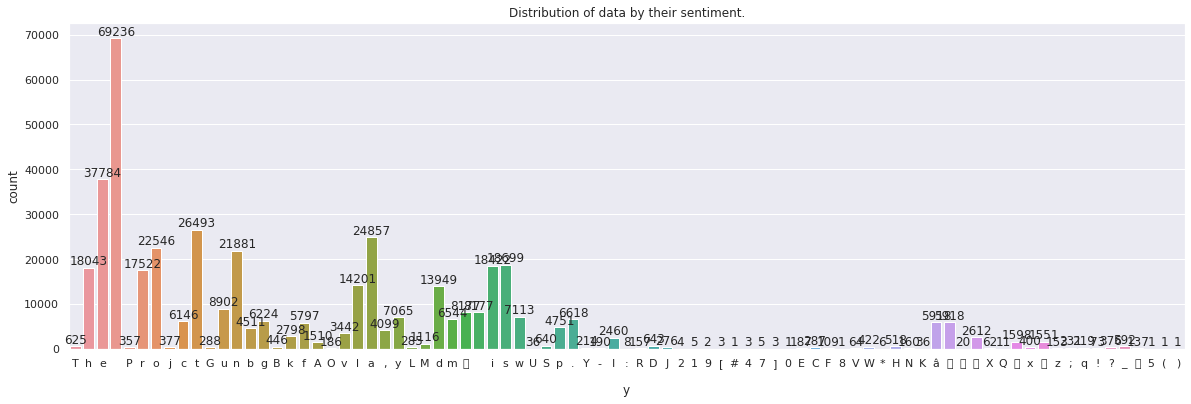

In [91]:
# How are the classes balanced? look at the most frequent byte
fig, ax = plt.subplots(figsize=(20,6))
sns.countplot(data=df, x=df.y, ax=ax)
ax.set_title("Distribution of data by their sentiment.")

for container in ax.containers:
    ax.bar_label(container)
plt.show()

In [99]:
# Take a look at the most frequent k sequence of previous bytes
# Compute frequency of every token 
dist = nltk.FreqDist(df.X.values)

In [100]:
# The most common tokens are
dist

FreqDist({' th': 5283, 'the': 4185, 'he ': 3904, 'â\x80\x99': 2612, 'nd ': 2589, ' an': 2576, 'and': 2538, ' to': 2362, 'ed ': 2351, 'ing': 2281, ...})

In [101]:
# Number of unique k sequences of previous bytes in train dataset
len(dist)

8190

[]

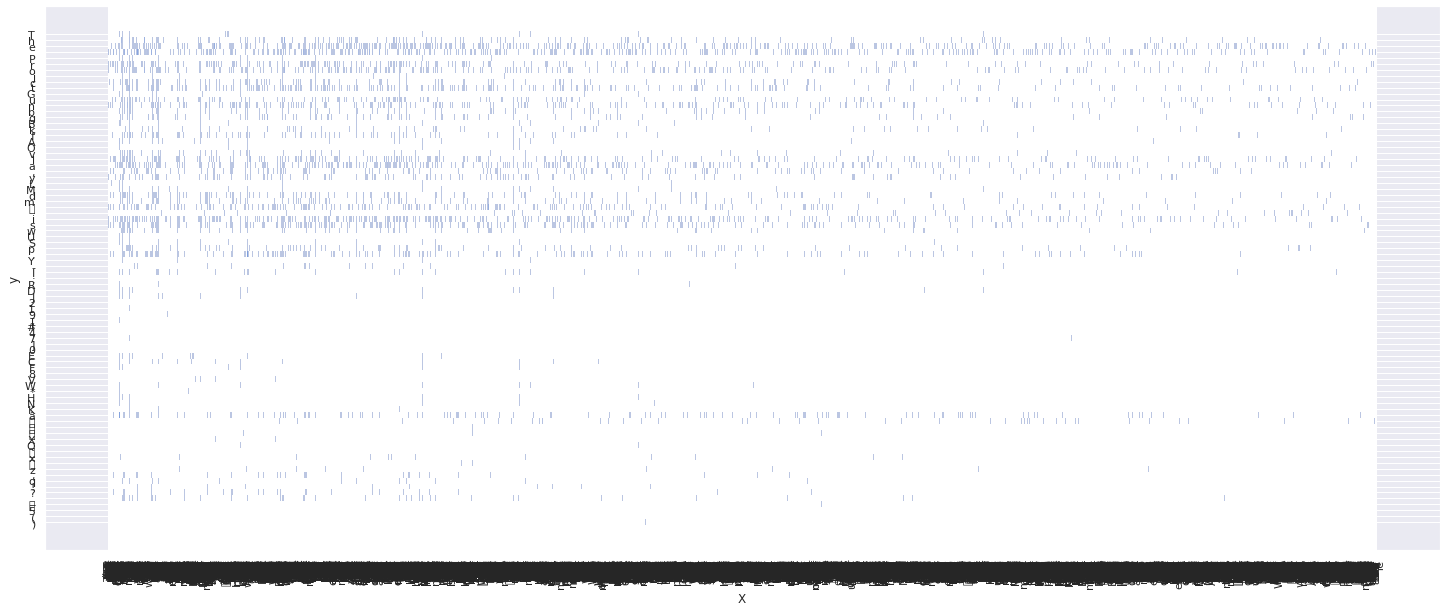

In [84]:
# Look at most frequent combination
fig, ax = plt.subplots(1, 1, figsize=(25,10))
sns.set_theme()
sns.histplot(df, x=df.X, y=df.y, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.plot()

In [86]:
warnings.filterwarnings("ignore")

/home/pta0054/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [85]:
warnings.filterwarnings("default")

### Compressed size of file using gzip


In [54]:
# run linux gzip and wc commands to get size of compressed file in bytes
gzip_process = subprocess.Popen(['gzip', '-c', test_filename], stdout=subprocess.PIPE, text=True)
wc_process = subprocess.Popen(['wc', '-c'], stdout=subprocess.PIPE, stdin=gzip_process.stdout, text=True)
output, error = wc_process.communicate()

In [55]:
# Check if commands ran succesfuly
compressed_file_size_in_bits = 0
if error is None:
    compressed_file_size_in_bits = int(output) * 8
    print(f"Size of compressed file using gzip in bits: {compressed_file_size_in_bits} b")
else:
    print(f"Command \"gzip -c {test_filename} | wc -c\" failed with error: {error}")
    
# Print compression rate achieved with using gzip
print("Compression ratio: ",calculate_compression_ratio(original_size_in_bits, compressed_file_size_in_bits))
print("Space saving: ", calculate_space_saving(original_size_in_bits, compressed_file_size_in_bits))

Size of compressed file using gzip in bits: 1605896 b
Compression ratio:  2.6496
Space saving:  0.6226


### Calculating Entropy using static frequencies

In [58]:
# Get alphabet of test file
characters = list(set([y[0] for y in test_y]))
len(characters)

90

In [59]:
# Calculate frequencies for each symbol of alphabet
frequency_table = { c:0 for c in characters }
for c in test_y:
    frequency_table[c[0]] += 1

In [60]:
# Calculate probabilities for each symbol of alphabet
probability_table = { c:0 for c in characters}
for c, f in frequency_table.items():
    probability_table[c] = f / len(test_y)

In [67]:
# Calculate avg entropy of whole test file for one character

H = 0
for c, p in probability_table.items():
    H -= (p) * np.log2(p)
print(H)
# Calculate entropy of whole file
H = H * len(test_y)
print(H)


4.659554492786191
2478314.524514134


In [62]:
# Calculate entropy of whole file
H = 0
for c in test_y:
    H -= 1 * np.log2(probability_table[c[0]])
H

2478314.5245074234

In [65]:
# Print predicted entropy of file (file size in bits) and original file size [bits]
H, original_size_in_bits

(2478314.5245074234, 4255048)

In [66]:
# Print potential compression rate, i.e. entropy of file
print("Compression ratio: ",calculate_compression_ratio(original_size_in_bits, H))
print("Space saving: ", calculate_space_saving(original_size_in_bits, H))

Compression ratio:  1.7169
Space saving:  0.4176


### Calculating entropy using Dense ANN predictions

In [46]:
batch_sizes = [128]

#### Model 0

Epoch 1/10
3325/3325 [==============================] - 26s 7ms/step - loss: 2.0458 - categorical_accuracy: 0.3965 - val_loss: 2.0892 - val_categorical_accuracy: 0.3936
Epoch 2/10
3325/3325 [==============================] - 27s 8ms/step - loss: 1.9360 - categorical_accuracy: 0.4116 - val_loss: 2.0682 - val_categorical_accuracy: 0.3982
Epoch 3/10
3325/3325 [==============================] - 26s 8ms/step - loss: 1.9186 - categorical_accuracy: 0.4144 - val_loss: 2.0563 - val_categorical_accuracy: 0.4015
Epoch 4/10
3325/3325 [==============================] - 31s 9ms/step - loss: 1.9102 - categorical_accuracy: 0.4155 - val_loss: 2.0448 - val_categorical_accuracy: 0.4034
Epoch 5/10
3325/3325 [==============================] - 29s 9ms/step - loss: 1.9037 - categorical_accuracy: 0.4166 - val_loss: 2.0483 - val_categorical_accuracy: 0.4034
Epoch 6/10
3325/3325 [==============================] - 27s 8ms/step - loss: 1.8995 - categorical_accuracy: 0.4168 - val_loss: 2.0378 - val_categorical_acc

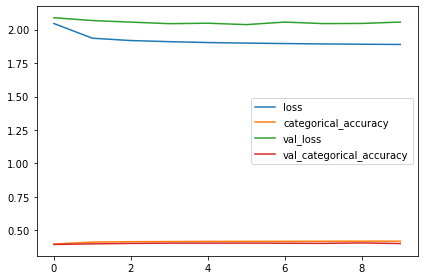

In [47]:
for b_s in batch_sizes:
    model = create_dense_model_0()
    weight_filepath = 'models/gutenberg/dense_00/weights/01.best.hdf5'
    model_filepath = 'models/gutenberg/dense_00/model/010'
    
    experiment(train_x, train_y, val_x, val_y, test_x, test_y, model, weight_filepath, model_filepath, original_size_in_bits, batch_size=b_s,
              epochs=10, shuffle=True, k=k)

#### Model 1

Epoch 1/10
3325/3325 [==============================] - 45s 13ms/step - loss: 2.1767 - categorical_accuracy: 0.3788 - val_loss: 2.2020 - val_categorical_accuracy: 0.3845
Epoch 2/10
3325/3325 [==============================] - 42s 13ms/step - loss: 2.0264 - categorical_accuracy: 0.4062 - val_loss: 2.1584 - val_categorical_accuracy: 0.3913
Epoch 3/10
3325/3325 [==============================] - 43s 13ms/step - loss: 1.9922 - categorical_accuracy: 0.4105 - val_loss: 2.1328 - val_categorical_accuracy: 0.3971
Epoch 4/10
3325/3325 [==============================] - 37s 11ms/step - loss: 1.9727 - categorical_accuracy: 0.4124 - val_loss: 2.1172 - val_categorical_accuracy: 0.3957
Epoch 5/10
3325/3325 [==============================] - 38s 12ms/step - loss: 1.9593 - categorical_accuracy: 0.4142 - val_loss: 2.1118 - val_categorical_accuracy: 0.3967
Epoch 6/10
3325/3325 [==============================] - 40s 12ms/step - loss: 1.9499 - categorical_accuracy: 0.4149 - val_loss: 2.1063 - val_categoric

INFO:tensorflow:Assets written to: models/dense_01/model/01/assets


4156/4156 [==============================] - 27s 6ms/step
Accuracy: 0.4108
Epoch 1/10
13297/13297 [==============================] - 151s 11ms/step - loss: 2.1206 - categorical_accuracy: 0.3885 - val_loss: 2.1724 - val_categorical_accuracy: 0.3891
Epoch 2/10
13297/13297 [==============================] - 116s 9ms/step - loss: 1.9933 - categorical_accuracy: 0.4088 - val_loss: 2.1548 - val_categorical_accuracy: 0.3918
Epoch 3/10
13297/13297 [==============================] - 97s 7ms/step - loss: 1.9649 - categorical_accuracy: 0.4117 - val_loss: 2.1229 - val_categorical_accuracy: 0.4002
Epoch 4/10
13297/13297 [==============================] - 97s 7ms/step - loss: 1.9508 - categorical_accuracy: 0.4131 - val_loss: 2.1114 - val_categorical_accuracy: 0.3980
Epoch 5/10
13297/13297 [==============================] - 97s 7ms/step - loss: 1.9428 - categorical_accuracy: 0.4131 - val_loss: 2.1150 - val_categorical_accuracy: 0.3977
Epoch 6/10
13297/13297 [==============================] - 98s 7ms/s

INFO:tensorflow:Assets written to: models/dense_01/model/01/assets


16622/16622 [==============================] - 59s 4ms/step
Accuracy: 0.4115


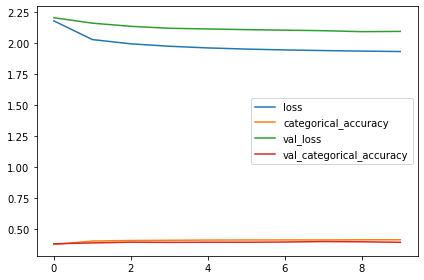

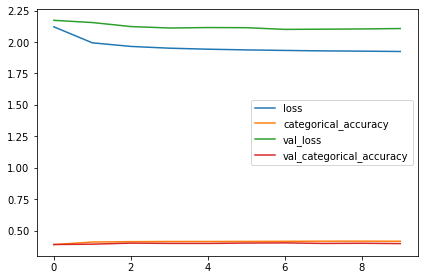

In [120]:
for b_s in batch_sizes:
    model = create_dense_model_1()
    weight_filepath = 'models/gutenberg/dense_01/weights/01.best.hdf5'
    model_filepath = 'models/gutenberg/dense_01/model/01'
    
    experiment(train_x, train_y, val_x, val_y, test_x, test_y, model, weight_filepath, model_filepath, original_size_in_bits, batch_size=b_s,
              epochs=10, shuffle=True, k=k)

#### Model 2

Epoch 1/10
3325/3325 [==============================] - 43s 13ms/step - loss: 2.2738 - categorical_accuracy: 0.3592 - val_loss: 2.2849 - val_categorical_accuracy: 0.3572
Epoch 2/10
3325/3325 [==============================] - 40s 12ms/step - loss: 2.1224 - categorical_accuracy: 0.3838 - val_loss: 2.2335 - val_categorical_accuracy: 0.3754
Epoch 3/10
3325/3325 [==============================] - 40s 12ms/step - loss: 2.0797 - categorical_accuracy: 0.3918 - val_loss: 2.2094 - val_categorical_accuracy: 0.3814
Epoch 4/10
3325/3325 [==============================] - 41s 12ms/step - loss: 2.0538 - categorical_accuracy: 0.3963 - val_loss: 2.1925 - val_categorical_accuracy: 0.3807
Epoch 5/10
3325/3325 [==============================] - 40s 12ms/step - loss: 2.0371 - categorical_accuracy: 0.3993 - val_loss: 2.1822 - val_categorical_accuracy: 0.3862
Epoch 6/10
3325/3325 [==============================] - 40s 12ms/step - loss: 2.0252 - categorical_accuracy: 0.4020 - val_loss: 2.1715 - val_categoric

INFO:tensorflow:Assets written to: models/dense_02/model/01/assets


4156/4156 [==============================] - 27s 6ms/step
Accuracy: 0.4046
Epoch 1/10
13297/13297 [==============================] - 148s 11ms/step - loss: 2.1937 - categorical_accuracy: 0.3732 - val_loss: 2.2303 - val_categorical_accuracy: 0.3764
Epoch 2/10
13297/13297 [==============================] - 137s 10ms/step - loss: 2.0592 - categorical_accuracy: 0.3954 - val_loss: 2.1936 - val_categorical_accuracy: 0.3843
Epoch 3/10
13297/13297 [==============================] - 146s 11ms/step - loss: 2.0242 - categorical_accuracy: 0.4027 - val_loss: 2.1777 - val_categorical_accuracy: 0.3879
Epoch 4/10
13297/13297 [==============================] - 145s 11ms/step - loss: 2.0068 - categorical_accuracy: 0.4076 - val_loss: 2.1754 - val_categorical_accuracy: 0.3914
Epoch 5/10
13297/13297 [==============================] - 146s 11ms/step - loss: 1.9955 - categorical_accuracy: 0.4086 - val_loss: 2.1662 - val_categorical_accuracy: 0.3920
Epoch 6/10
13297/13297 [==============================] - 13

INFO:tensorflow:Assets written to: models/dense_02/model/01/assets


16622/16622 [==============================] - 44s 3ms/step
Accuracy: 0.4067


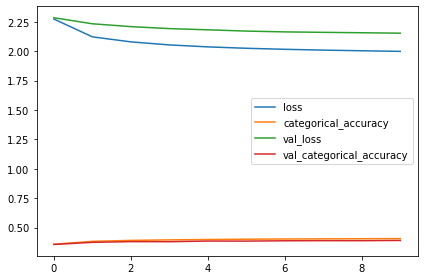

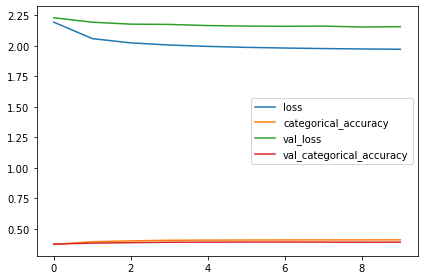

In [121]:
for b_s in batch_sizes:
    model = create_dense_model_2()
    weight_filepath = 'models/gutenberg/dense_02/weights/01.best.hdf5'
    model_filepath = 'models/gutenberg/dense_02/model/01'
    
    experiment(train_x, train_y, val_x, val_y, test_x, test_y, model, weight_filepath, model_filepath, original_size_in_bits, batch_size=b_s,
              epochs=10, shuffle=True, k=k)

### Calculating entropy using Recurrent ANN predictions

#### Model 0

Epoch 1/5
3325/3325 [==============================] - 246s 72ms/step - loss: 2.2782 - categorical_accuracy: 0.3571 - val_loss: 2.2234 - val_categorical_accuracy: 0.3839
Epoch 2/5
3325/3325 [==============================] - 323s 97ms/step - loss: 2.0506 - categorical_accuracy: 0.4023 - val_loss: 2.1851 - val_categorical_accuracy: 0.3938
Epoch 3/5
3325/3325 [==============================] - 251s 75ms/step - loss: 2.0393 - categorical_accuracy: 0.4049 - val_loss: 2.2346 - val_categorical_accuracy: 0.3995
Epoch 4/5
3325/3325 [==============================] - 237s 71ms/step - loss: 2.0574 - categorical_accuracy: 0.4016 - val_loss: 2.1990 - val_categorical_accuracy: 0.3866
Epoch 5/5
3325/3325 [==============================] - 234s 70ms/step - loss: 2.0809 - categorical_accuracy: 0.3977 - val_loss: 2.2241 - val_categorical_accuracy: 0.3897
INFO:tensorflow:Assets written to: models/recurrent_00/model/00/assets


INFO:tensorflow:Assets written to: models/recurrent_00/model/00/assets


4156/4156 [==============================] - 38s 9ms/step
Accuracy: 0.4093


Epoch 1/5
13297/13297 [==============================] - 970s 72ms/step - loss: 2.2735 - categorical_accuracy: 0.3662 - val_loss: 2.3247 - val_categorical_accuracy: 0.3661
Epoch 2/5
13297/13297 [==============================] - 949s 71ms/step - loss: 2.2984 - categorical_accuracy: 0.3659 - val_loss: 2.4796 - val_categorical_accuracy: 0.3333
Epoch 3/5
13297/13297 [==============================] - 953s 72ms/step - loss: 2.4378 - categorical_accuracy: 0.3408 - val_loss: 2.5593 - val_categorical_accuracy: 0.3205
Epoch 4/5
13297/13297 [==============================] - 930s 70ms/step - loss: 2.5898 - categorical_accuracy: 0.3121 - val_loss: 2.9685 - val_categorical_accuracy: 0.3149
Epoch 5/5
13297/13297 [==============================] - 941s 71ms/step - loss: 2.7339 - categorical_accuracy: 0.2838 - val_loss: 2.8594 - val_categorical_accuracy: 0.2678
INFO:tensorflow:Assets written to: models/recurrent_00/model/00/assets


INFO:tensorflow:Assets written to: models/recurrent_00/model/00/assets


16622/16622 [==============================] - 147s 9ms/step
Accuracy: 0.3784


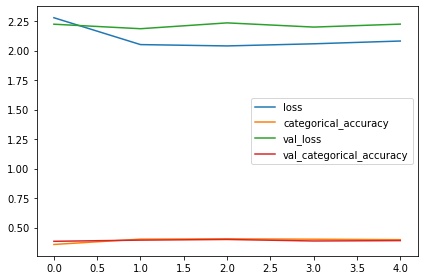

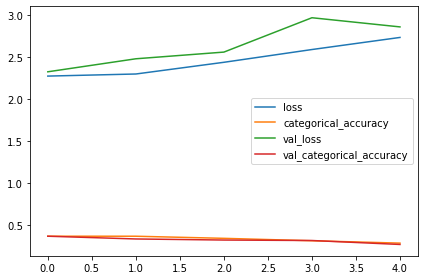

In [122]:
for b_s in batch_sizes:
    model = create_recurrent_model_0()
    weight_filepath = 'models/gutenberg/recurrent_00/weights/00.best.hdf5'
    model_filepath = 'models/gutenberg/recurrent_00/model/00'
    
    experiment(train_x, train_y, val_x, val_y, test_x, test_y, model, weight_filepath, model_filepath, original_size_in_bits, batch_size=b_s,
              epochs=5, shuffle=True, k=k)

#### Model 1

Epoch 1/5
3325/3325 [==============================] - 69s 19ms/step - loss: 2.5443 - categorical_accuracy: 0.2996 - val_loss: 2.3892 - val_categorical_accuracy: 0.3510
Epoch 2/5
3325/3325 [==============================] - 60s 18ms/step - loss: 2.1649 - categorical_accuracy: 0.3809 - val_loss: 2.2971 - val_categorical_accuracy: 0.3779
Epoch 3/5
3325/3325 [==============================] - 62s 19ms/step - loss: 2.0933 - categorical_accuracy: 0.3980 - val_loss: 2.2587 - val_categorical_accuracy: 0.3882
Epoch 4/5
3325/3325 [==============================] - 60s 18ms/step - loss: 2.0547 - categorical_accuracy: 0.4039 - val_loss: 2.2163 - val_categorical_accuracy: 0.3937
Epoch 5/5
3325/3325 [==============================] - 63s 19ms/step - loss: 2.0309 - categorical_accuracy: 0.4063 - val_loss: 2.2100 - val_categorical_accuracy: 0.3929


INFO:tensorflow:Assets written to: models/recurrent_01/model/00/assets


INFO:tensorflow:Assets written to: models/recurrent_01/model/00/assets


4156/4156 [==============================] - 22s 5ms/step
Accuracy: 0.4057
Epoch 1/5
13297/13297 [==============================] - 240s 18ms/step - loss: 2.3547 - categorical_accuracy: 0.3402 - val_loss: 2.3330 - val_categorical_accuracy: 0.3691
Epoch 2/5
13297/13297 [==============================] - 237s 18ms/step - loss: 2.1468 - categorical_accuracy: 0.3901 - val_loss: 2.2910 - val_categorical_accuracy: 0.3796
Epoch 3/5
13297/13297 [==============================] - 231s 17ms/step - loss: 2.1230 - categorical_accuracy: 0.3960 - val_loss: 2.2815 - val_categorical_accuracy: 0.3765
Epoch 4/5
13297/13297 [==============================] - 233s 18ms/step - loss: 2.1136 - categorical_accuracy: 0.3978 - val_loss: 2.2802 - val_categorical_accuracy: 0.3881
Epoch 5/5
13297/13297 [==============================] - 256s 19ms/step - loss: 2.1080 - categorical_accuracy: 0.3999 - val_loss: 2.2890 - val_categorical_accuracy: 0.3811


INFO:tensorflow:Assets written to: models/recurrent_01/model/00/assets


INFO:tensorflow:Assets written to: models/recurrent_01/model/00/assets


16622/16622 [==============================] - 89s 5ms/step
Accuracy: 0.3957


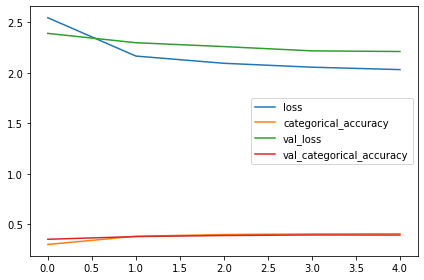

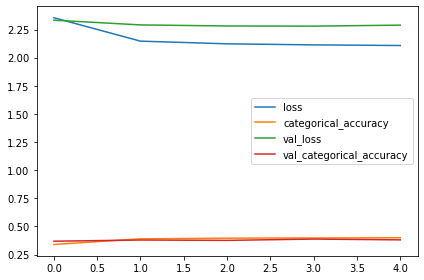

In [123]:
for b_s in batch_sizes:
    model = create_recurrent_model_1()
    weight_filepath = 'models/gutenberg/recurrent_01/weights/00.best.hdf5'
    model_filepath = 'models/gutenberg/recurrent_01/model/00'
    
    experiment(train_x, train_y, val_x, val_y, test_x, test_y, model, weight_filepath, model_filepath, original_size_in_bits, batch_size=b_s,
              epochs=5, shuffle=True, k=k)

#### Model 2

Epoch 1/5
3325/3325 [==============================] - 91s 27ms/step - loss: 2.5434 - categorical_accuracy: 0.3031 - val_loss: 2.4213 - val_categorical_accuracy: 0.3442
Epoch 2/5
3325/3325 [==============================] - 87s 26ms/step - loss: 2.2090 - categorical_accuracy: 0.3710 - val_loss: 2.3339 - val_categorical_accuracy: 0.3639
Epoch 3/5
3325/3325 [==============================] - 87s 26ms/step - loss: 2.1387 - categorical_accuracy: 0.3856 - val_loss: 2.3009 - val_categorical_accuracy: 0.3757
Epoch 4/5
3325/3325 [==============================] - 86s 26ms/step - loss: 2.1035 - categorical_accuracy: 0.3919 - val_loss: 2.2832 - val_categorical_accuracy: 0.3792
Epoch 5/5
3325/3325 [==============================] - 83s 25ms/step - loss: 2.0806 - categorical_accuracy: 0.3973 - val_loss: 2.2620 - val_categorical_accuracy: 0.3833
INFO:tensorflow:Assets written to: models/recurrent_02/model/00/assets


INFO:tensorflow:Assets written to: models/recurrent_02/model/00/assets


4156/4156 [==============================] - 23s 6ms/step
Accuracy: 0.3953


Epoch 1/5
13297/13297 [==============================] - 332s 25ms/step - loss: 2.3848 - categorical_accuracy: 0.3390 - val_loss: 2.3722 - val_categorical_accuracy: 0.3603
Epoch 2/5
13297/13297 [==============================] - 330s 25ms/step - loss: 2.1884 - categorical_accuracy: 0.3851 - val_loss: 2.3436 - val_categorical_accuracy: 0.3759
Epoch 3/5
13297/13297 [==============================] - 332s 25ms/step - loss: 2.1841 - categorical_accuracy: 0.3887 - val_loss: 2.3771 - val_categorical_accuracy: 0.3710
Epoch 4/5
13297/13297 [==============================] - 320s 24ms/step - loss: 2.2161 - categorical_accuracy: 0.3837 - val_loss: 2.4003 - val_categorical_accuracy: 0.3669
Epoch 5/5
13297/13297 [==============================] - 345s 26ms/step - loss: 2.2708 - categorical_accuracy: 0.3729 - val_loss: 2.4497 - val_categorical_accuracy: 0.3479
INFO:tensorflow:Assets written to: models/recurrent_02/model/00/assets


INFO:tensorflow:Assets written to: models/recurrent_02/model/00/assets


16622/16622 [==============================] - 77s 5ms/step
Accuracy: 0.3846


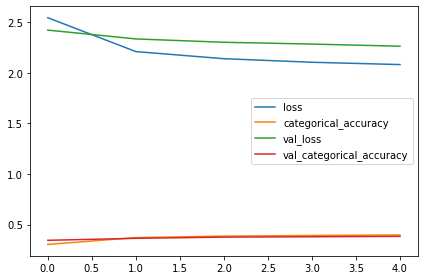

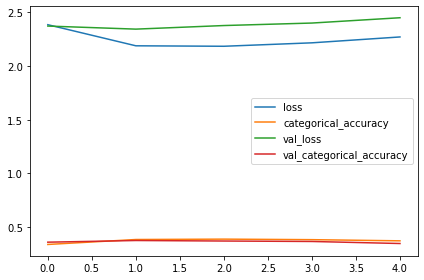

In [124]:
for b_s in batch_sizes:
    model = create_recurrent_model_2()
    weight_filepath = 'models/gutenberg/recurrent_02/weights/00.best.hdf5'
    model_filepath = 'models/gutenberg/recurrent_02/model/00'
    
    experiment(train_x, train_y, val_x, val_y, test_x, test_y, model, weight_filepath, model_filepath, original_size_in_bits, batch_size=b_s,
              epochs=5, shuffle=True, k=k)

#### Model 3

Epoch 1/5
3325/3325 [==============================] - 73s 21ms/step - loss: 2.7650 - categorical_accuracy: 0.2655 - val_loss: 2.5085 - val_categorical_accuracy: 0.3228
Epoch 2/5
3325/3325 [==============================] - 69s 21ms/step - loss: 2.3128 - categorical_accuracy: 0.3477 - val_loss: 2.4249 - val_categorical_accuracy: 0.3486
Epoch 3/5
3325/3325 [==============================] - 70s 21ms/step - loss: 2.2398 - categorical_accuracy: 0.3636 - val_loss: 2.3846 - val_categorical_accuracy: 0.3602
Epoch 4/5
3325/3325 [==============================] - 69s 21ms/step - loss: 2.1992 - categorical_accuracy: 0.3724 - val_loss: 2.3580 - val_categorical_accuracy: 0.3639
Epoch 5/5
3325/3325 [==============================] - 70s 21ms/step - loss: 2.1741 - categorical_accuracy: 0.3801 - val_loss: 2.3479 - val_categorical_accuracy: 0.3673
INFO:tensorflow:Assets written to: models/recurrent_03/model/00/assets


INFO:tensorflow:Assets written to: models/recurrent_03/model/00/assets


4156/4156 [==============================] - 23s 5ms/step
Accuracy: 0.3795


Epoch 1/5
13297/13297 [==============================] - 278s 21ms/step - loss: 2.5148 - categorical_accuracy: 0.3105 - val_loss: 2.4608 - val_categorical_accuracy: 0.3362
Epoch 2/5
13297/13297 [==============================] - 268s 20ms/step - loss: 2.2789 - categorical_accuracy: 0.3633 - val_loss: 2.4249 - val_categorical_accuracy: 0.3602
Epoch 3/5
13297/13297 [==============================] - 262s 20ms/step - loss: 2.2515 - categorical_accuracy: 0.3714 - val_loss: 2.4110 - val_categorical_accuracy: 0.3566
Epoch 4/5
13297/13297 [==============================] - 260s 20ms/step - loss: 2.2388 - categorical_accuracy: 0.3748 - val_loss: 2.4087 - val_categorical_accuracy: 0.3578
Epoch 5/5
13297/13297 [==============================] - 260s 20ms/step - loss: 2.2391 - categorical_accuracy: 0.3763 - val_loss: 2.4158 - val_categorical_accuracy: 0.3565
INFO:tensorflow:Assets written to: models/recurrent_03/model/00/assets


INFO:tensorflow:Assets written to: models/recurrent_03/model/00/assets


16622/16622 [==============================] - 58s 3ms/step
Accuracy: 0.3695


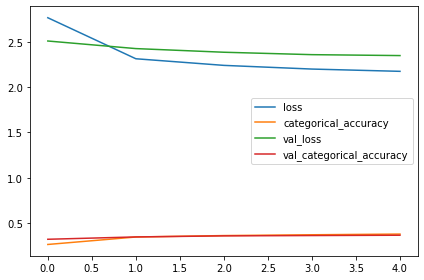

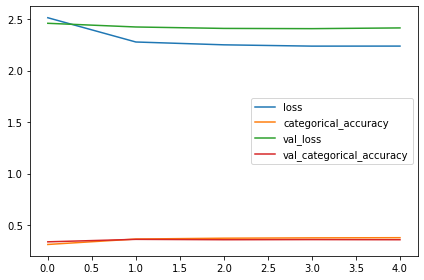

In [125]:
for b_s in batch_sizes:
    model = create_recurrent_model_3()
    weight_filepath = 'models/gutenberg/recurrent_03/weights/00.best.hdf5'
    model_filepath = 'models/gutenberg/recurrent_03/model/00'
    
    experiment(train_x, train_y, val_x, val_y, test_x, test_y, model, weight_filepath, model_filepath, original_size_in_bits, batch_size=b_s,
              epochs=5, shuffle=True, k=k)

### Load data for general model

In [332]:
# Load test_x and test_y as bytes from one file
test_filename = r"./data/gutenberg/test/47-0.txt"
test_x, test_y, test_loaded_size = load_data_binary(test_filename, seed=42, lengthOfSubstring=k, portion=1, max_size_in_bytes=5_000_000)
test_x = np.array(test_x)
test_y = np.array(test_y)
print(f"\nSize of test dataset: {len(test_y)} B [{test_loaded_size / 1000 / 1000} MB]")

Loaded bytes [10.6 %]
Size of test dataset: 531880 B [0.5318809999999999 MB]


In [24]:
# Load train_x and train_y as bytes
# Training on more data
"""
train_filename = r"./data/gutenberg/train/*-0.txt"
train_x, train_y, train_loaded_size = load_data_binary(train_filename, seed=42, lengthOfSubstring=k, portion=0.15, max_size_in_bytes=5_000_000)
train_x = np.array(train_x)
train_y = np.array(train_y)
print(f"\nSize of train dataset: {len(train_y)} B [{train_loaded_size / 1000 / 1000} MB]")
"""

Loaded bytes [100.0 %]
Size of train dataset: 5000000 [5.061781 MB]


In [22]:
# Split train set into - train and validation set
# WITH shuffle
#train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42, shuffle=True)
# WITHOUT shuffle
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42, shuffle=False)

In [23]:
print(f"Train data: {round(len(train_y) / (len(test_y) + len(train_y) + len(val_y)) * 100, 2) } %")
print(f"Validation data: {round(len(val_y) / (len(test_y) + len(train_y) + len(val_y)) * 100, 2) } %")
print(f"Test data: {round(len(test_y) / (len(test_y) + len(train_y) + len(val_y)) * 100, 2) } %")

Train data: 75.01 %
Validation data: 18.75 %
Test data: 6.24 %


In [24]:
# Size of train, validation and test datasets
print(f"Train set size (X, y): {train_x.shape}, {train_y.shape}")
print(f"Validation set size (X, y): {val_x.shape}, {val_y.shape}")
print(f"Test set size (X, y): {test_x.shape}, {test_y.shape}")

Train set size (X, y): (6392225, 64), (6392225, 1)
Validation set size (X, y): (1598057, 64), (1598057, 1)
Test set size (X, y): (531817, 64), (531817, 1)


In [25]:
# get original size of file in bits
original_size_in_bits = len(test_y) * 8
original_size_in_bits

4254536

### Calculating Entropy using dynamic ANN predictions

#### Using Dense ANN


##### Model 1

In [34]:
# Create checkpoint for storing only best results
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights_dense_model_01_02.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

batch_size = 2048
epochs = 10

train_gen = DataGenerator(train_x, train_y, batch_size)
val_gen = DataGenerator(val_x, val_y, batch_size)

# Shuffle train data at start of each epoch
# Fit model.
history_dense_model = dense_model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[model_checkpoint_callback], shuffle=True)

Epoch 1/10
1484/1484 [==============================] - 185s 124ms/step - loss: 2.0173 - categorical_accuracy: 0.4252 - val_loss: 1.6847 - val_categorical_accuracy: 0.5052
Epoch 2/10
1484/1484 [==============================] - 188s 127ms/step - loss: 1.6300 - categorical_accuracy: 0.5152 - val_loss: 1.5657 - val_categorical_accuracy: 0.5395
Epoch 3/10
1484/1484 [==============================] - 189s 127ms/step - loss: 1.5129 - categorical_accuracy: 0.5451 - val_loss: 1.5119 - val_categorical_accuracy: 0.5538
Epoch 4/10
1484/1484 [==============================] - 190s 128ms/step - loss: 1.4480 - categorical_accuracy: 0.5609 - val_loss: 1.4932 - val_categorical_accuracy: 0.5593
Epoch 5/10
1484/1484 [==============================] - 188s 126ms/step - loss: 1.4048 - categorical_accuracy: 0.5713 - val_loss: 1.4900 - val_categorical_accuracy: 0.5628
Epoch 6/10
1484/1484 [==============================] - 189s 127ms/step - loss: 1.3735 - categorical_accuracy: 0.5788 - val_loss: 1.4817 - v

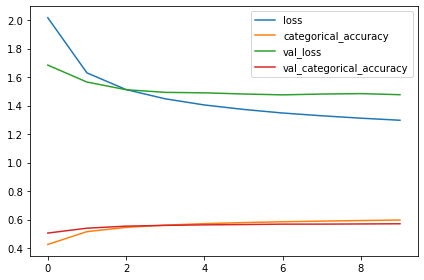

In [35]:
show_history(history_dense_model)

In [36]:
# Save trained weights and biases.
dense_model.save('models/model_dense_01_02')

INFO:tensorflow:Assets written to: models/model_dense_01_02/assets


INFO:tensorflow:Assets written to: models/model_dense_01_02/assets


In [26]:
# Load trained model
dense_model = tf.keras.models.load_model(r"models/model_dense_1", custom_objects={"loss_fn": loss_fn})

In [37]:
# Make predictions on data
batch_size = 2048
test_gen = DataGenerator(test_x, test_y, batch_size)

# Load best setup
dense_model.load_weights('weights_dense_model_01_02.best.hdf5')
pred_y = dense_model.predict(test_gen)

260/260 [==============================] - 25s 97ms/step


In [71]:
# Calculate conditional entropy
H_yx = 0
for i,x in enumerate(test_x):
    #print(x)
    #print(test_x[0])
    #print(x == test_x[0])
    t_x = sum([1 for _x in test_x if all(_x == x)])
    p_x = t_x / len(test_x)
    print(f"{i / len(test_x) * 100}\r", end="")
    for j, y in enumerate(test_y):
        p_yx = np.max(pred_y[j])
        #print(p_yx)
        H_yx -= p_x*p_yx*np.log2(p_yx)
        
predicted_size_in_bits = H_yx

KeyboardInterrupt: 

In [38]:
# Calculate predicted size of file after compresion using predicted probabilities
predicted_size_in_bits = 0
for prediction in pred_y:
    highest_probability = np.max(prediction[0])
    #print(highest_probability, predicted_size_in_bits)
    predicted_size_in_bits -= 1 * (np.log2(highest_probability))


In [39]:
# Print predicted compressed file size and original not compressed file size
predicted_size_in_bits, original_size_in_bits

(575897.6389510403, 4254792)

In [40]:
# Print compression rate
print((1 - (predicted_size_in_bits / original_size_in_bits)) * 100, "%")

86.46472873524628 %


In [42]:
# Calculate accuracy on test data
accuracy = calculate_accuracy(pred_y, test_y)
print(f"Accuracy: {round(accuracy * 100, 2)} %")

Accuracy: 53.89 %


##### Model 2

In [35]:
# Create checkpoint for storing only best results
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights_dense_model_02_03.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

batch_size = 1024
epochs = 10

train_gen = DataGenerator(train_x, train_y, batch_size)
val_gen = DataGenerator(val_x, val_y, batch_size)

# Shuffle train data at start of each epoch
# Fit model.
history_dense_model = dense_model_2.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[model_checkpoint_callback], shuffle=True)

Epoch 1/10
6243/6243 [==============================] - 681s 109ms/step - loss: 1.2974 - categorical_accuracy: 0.6010 - val_loss: 1.4746 - val_categorical_accuracy: 0.5589
Epoch 2/10
6243/6243 [==============================] - 697s 112ms/step - loss: 1.2595 - categorical_accuracy: 0.6112 - val_loss: 1.4754 - val_categorical_accuracy: 0.5590
Epoch 3/10
6243/6243 [==============================] - 713s 114ms/step - loss: 1.2339 - categorical_accuracy: 0.6182 - val_loss: 1.4772 - val_categorical_accuracy: 0.5608
Epoch 4/10
6243/6243 [==============================] - 658s 105ms/step - loss: 1.2134 - categorical_accuracy: 0.6240 - val_loss: 1.4825 - val_categorical_accuracy: 0.5590
Epoch 5/10
6243/6243 [==============================] - 676s 108ms/step - loss: 1.1938 - categorical_accuracy: 0.6292 - val_loss: 1.4883 - val_categorical_accuracy: 0.5608
Epoch 6/10
6243/6243 [==============================] - 648s 104ms/step - loss: 1.1781 - categorical_accuracy: 0.6336 - val_loss: 1.4971 - v

In [36]:
# Save trained weights and biases.
dense_model_2.save('models/model_dense_02_03')

INFO:tensorflow:Assets written to: models/model_dense_02_03/assets


In [37]:
# Make predictions on data
batch_size = 1024
test_gen = DataGenerator(test_x, test_y, batch_size)

# Load best setup
dense_model_2.load_weights('weights_dense_model_02_03.best.hdf5')
pred_y = dense_model_2.predict(test_gen)

520/520 [==============================] - 54s 103ms/step


In [39]:
# Calculate predicted size of file after compresion using predicted probabilities
predicted_size_in_bits = 0
for prediction in pred_y:
    highest_probability = np.max(prediction[0])
    #print(highest_probability, predicted_size_in_bits)
    predicted_size_in_bits -= 1 * (np.log2(highest_probability))


In [40]:
# Print predicted compressed file size and original not compressed file size
predicted_size_in_bits, original_size_in_bits

(526186.2157041633, 4254536)

In [41]:
# Print compression rate
print((1 - (predicted_size_in_bits / original_size_in_bits)) * 100, "%")

87.6323477882391 %


In [38]:
# Calculate accuracy on test data
accuracy = calculate_accuracy(pred_y, test_y)
print(f"Accuracy: {round(accuracy * 100, 2)} %")

Accuracy: 53.63 %


#### Using Recurrent ANN

##### Model 1

In [45]:
# Create checkpoint for storing only best results
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights_recurrent_model_01_01.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

batch_size = 2048
epochs = 5

train_gen = DataGenerator(train_x, train_y, batch_size)
val_gen = DataGenerator(val_x, val_y, batch_size)


# Fit model.
history_recurrent_model = recurrent_model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[model_checkpoint_callback])

Epoch 1/5
1484/1484 [==============================] - 1017s 683ms/step - loss: 2.3974 - categorical_accuracy: 0.3265 - val_loss: 1.9696 - val_categorical_accuracy: 0.4304
Epoch 2/5
1484/1484 [==============================] - 1302s 877ms/step - loss: 1.8883 - categorical_accuracy: 0.4460 - val_loss: 1.7426 - val_categorical_accuracy: 0.4887
Epoch 3/5
1484/1484 [==============================] - 1081s 728ms/step - loss: 1.7194 - categorical_accuracy: 0.4899 - val_loss: 1.6583 - val_categorical_accuracy: 0.5152
Epoch 4/5
1484/1484 [==============================] - 1161s 782ms/step - loss: 1.6290 - categorical_accuracy: 0.5138 - val_loss: 1.6082 - val_categorical_accuracy: 0.5257
Epoch 5/5
1484/1484 [==============================] - 1216s 819ms/step - loss: 1.5738 - categorical_accuracy: 0.5288 - val_loss: 1.5616 - val_categorical_accuracy: 0.5407


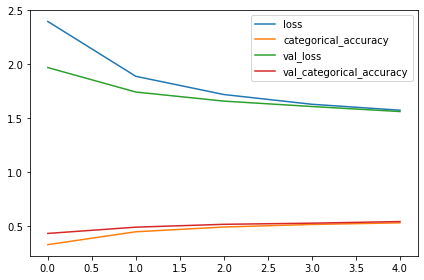

In [46]:
show_history(history_recurrent_model)

In [47]:
# Save trained weights and biases.
recurrent_model.save('models/model_recurrent_01_01')

INFO:tensorflow:Assets written to: models/model_recurrent_01_01/assets


INFO:tensorflow:Assets written to: models/model_recurrent_01_01/assets


In [224]:
# Load trained model
recurrent_model = tf.keras.models.load_model(r"models/model_recurrent")

In [48]:
# Make predictions on data
batch_size = 2048
test_gen = DataGenerator(test_x, test_y, batch_size)

# Load best setup
recurrent_model.load_weights('weights_recurrent_model_01_01.best.hdf5')
pred_y = recurrent_model.predict(test_gen)

260/260 [==============================] - 30s 114ms/step


In [55]:
# Calculate predicted size of file after compresion using predicted probabilities
predicted_size_in_bits = 0
for prediction in pred_y:
    highest_probability = np.max(prediction[0])
    predicted_size_in_bits -=  1 * np.log2(highest_probability)

In [56]:
# Print predicted compressed file size and original not compressed file size
predicted_size_in_bits, original_size_in_bits

(594229.9857914086, 4254792)

In [57]:
# Print compression rate
print((1 - (predicted_size_in_bits / original_size_in_bits)) * 100, "%")

86.033865209124 %


In [58]:
# Calculate accuracy on test data
accuracy = calculate_accuracy(pred_y, test_y)
print(f"Accuracy: {round(accuracy * 100, 2)} %")

Accuracy: 51.84 %


##### Model 2

In [22]:
# Create checkpoint for storing only best results
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights_recurrent_model_02_02.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

batch_size = 2048
epochs = 10

train_gen = DataGenerator(train_x, train_y, batch_size)
val_gen = DataGenerator(val_x, val_y, batch_size)


# Fit model.
history_recurrent_model = recurrent_model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[model_checkpoint_callback], shuffle=False)

Epoch 1/10
1484/1484 [==============================] - 187s 123ms/step - loss: 2.7633 - categorical_accuracy: 0.2414 - val_loss: 2.2934 - val_categorical_accuracy: 0.3432
Epoch 2/10
1484/1484 [==============================] - 179s 121ms/step - loss: 2.2313 - categorical_accuracy: 0.3598 - val_loss: 2.0971 - val_categorical_accuracy: 0.4010
Epoch 3/10
1484/1484 [==============================] - 183s 123ms/step - loss: 2.0990 - categorical_accuracy: 0.3917 - val_loss: 2.0138 - val_categorical_accuracy: 0.4269
Epoch 4/10
1484/1484 [==============================] - 185s 124ms/step - loss: 2.0273 - categorical_accuracy: 0.4113 - val_loss: 1.9596 - val_categorical_accuracy: 0.4392
Epoch 5/10
1484/1484 [==============================] - 183s 123ms/step - loss: 1.9752 - categorical_accuracy: 0.4246 - val_loss: 1.9167 - val_categorical_accuracy: 0.4501
Epoch 6/10
1484/1484 [==============================] - 213s 143ms/step - loss: 1.9354 - categorical_accuracy: 0.4349 - val_loss: 1.8835 - v

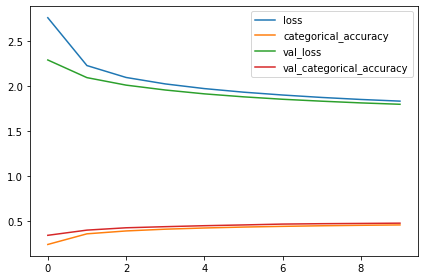

In [31]:
show_history(history_recurrent_model)

In [23]:
# Save trained weights and biases.
recurrent_model.save('models/model_recurrent_02_02')

INFO:tensorflow:Assets written to: models/model_recurrent_02_02/assets


INFO:tensorflow:Assets written to: models/model_recurrent_02_02/assets


In [213]:
# Load trained model
recurrent_model = tf.keras.models.load_model(r"models/model_recurrent_1", custom_objects={"loss_fn": loss_fn})

In [25]:
# Make predictions on data
batch_size = 2048
test_gen = DataGenerator(test_x, test_y, batch_size)

# Load best setup
recurrent_model.load_weights('weights_recurrent_model_02_02.best.hdf5')
pred_y = recurrent_model.predict(test_gen)

260/260 [==============================] - 26s 99ms/step


In [323]:
test_y

array([[b'G'],
       [b'T'],
       [b'T'],
       ...,
       [b'T'],
       [b'G'],
       [b'T']], dtype='|S1')

In [26]:
# Calculate predicted size of file after compresion using predicted probabilities
predicted_size_in_bits = 0
for prediction in pred_y:
    highest_probability = np.max(prediction[0])
    predicted_size_in_bits -=  1 * np.log2(highest_probability)

In [27]:
# Print predicted compressed file size and original not compressed file size
predicted_size_in_bits, original_size_in_bits

(766053.0538405506, 4254792)

In [28]:
# Print compression rate
print((1 - (predicted_size_in_bits / original_size_in_bits)) * 100, "%")

81.9955228401165 %


In [29]:
# sum (log_2(p(x1)), log_2(p(x2)), log_2(p(x3)), ...). 
# Dále výsledná velikost celého souboru je velikost neuronky + velikost souboru(suma log_2)

In [30]:
# Calculate accuracy on test data
accuracy = calculate_accuracy(pred_y, test_y)
print(f"Accuracy: {round(accuracy * 100, 2)} %")

Accuracy: 46.14 %


In [84]:
# Create probability table
probability_table = {}
for i in range(0, 256):
    probabilities = [prediction[0][i] for prediction in pred_y]
    print(f"{int.to_bytes(i, length=1, byteorder='big')}: {np.mean(probabilities)}")
    probability_table[int.to_bytes(i, length=1, byteorder='big')] = np.mean(probabilities).item()
    #print(probabilities)

b'\x00': 1.6955372217353215e-08
b'\x01': 1.7074352598456244e-08
b'\x02': 1.693106987943338e-08
b'\x03': 1.6755979714844216e-08
b'\x04': 1.70504961261031e-08
b'\x05': 1.7056096979217727e-08
b'\x06': 1.7071206670493666e-08
b'\x07': 1.695195095408053e-08
b'\x08': 1.6980489903062335e-08
b'\t': 1.697185503246601e-08
b'\n': 0.019046396017074585
b'\x0b': 1.691066309206235e-08
b'\x0c': 1.6869897478954954e-08
b'\r': 0.01906692609190941
b'\x0e': 1.7020584053284438e-08
b'\x0f': 1.703186569557147e-08
b'\x10': 1.6807140568175782e-08
b'\x11': 1.687139139505689e-08
b'\x12': 1.688018258505508e-08
b'\x13': 1.698325391430444e-08
b'\x14': 1.7040205690932453e-08
b'\x15': 1.6931148039134314e-08
b'\x16': 1.6972881766719183e-08
b'\x17': 1.6993343621152235e-08
b'\x18': 1.6903680233326668e-08
b'\x19': 1.7134620833303416e-08
b'\x1a': 1.6892290233272433e-08
b'\x1b': 1.6942642844242073e-08
b'\x1c': 1.6836478877735317e-08
b'\x1d': 1.689034334617645e-08
b'\x1e': 1.6853309858788634e-08
b'\x1f': 1.7044587963255253e-0

In [78]:
[test_y.reshape(len(test_y))]

[array([b'T', b'h', b'e', ..., b'\n', b'\r', b'\n'], dtype='|S1')]

In [163]:
decimal_precision = 1500

In [164]:
decimal.getcontext().prec = decimal_precision
# Original data
original_data = test_y.reshape(len(test_y))
original_data = original_data
# Create coder
arithmetic_coder = ArithmeticCoder(probability_table=probability_table)
# Encode data
encoded_msg, encoder , interval_min_value, interval_max_value = arithmetic_coder.encode(data=original_data, probability_table=arithmetic_coder.probability_table)

encoded_msg, interval_min_value, interval_max_value

(Decimal('0.2456289323900659482566261042880203518532094200636283646641339565203990374024143881872737964440430567747371360227098918615252613052355095259006356354583048667297510732686319672508588358259684862205413393883527195375400892035304746068361840833633673855944594692640961992878275386642168999684603760444843767321306893597707848758946524854954060947898370691173071586030428022661376292986127364784665557495706471023288387168203418366903006442655637723529963939307735454048508298990476049884268669576694294165576979027056718088838158914978799194761053776835202069876224306804069534337450440301050569338045556357890341208046740364574773358876256402136558190453982462814874459999276504403152302769473334984719627714698801248371215976879793921088312778685136311207383685696918061019916231756556171692113033981616035045747293074999973803411196846898609216155873115829332567489925534556135072847963665150851945856496467113734256418100854126466626241626746881777515412914915508177096375182020350632010

In [165]:
decimal.getcontext().prec = decimal_precision
# Decode data
decoded_msg, decoder = arithmetic_coder.decode(data=encoded_msg, data_length=len(original_data), probability_table=arithmetic_coder.probability_table)
decoded_msg_as_string = "".join([chr(int.from_bytes(x, "big")) for x in decoded_msg])
original_data_as_string = ''.join([chr(int.from_bytes(x, 'big')) for x in original_data])
#print(f"Decoded Message:\t{decoded_msg_as_string}")
#print(f"Original Message:\t{original_data_as_string}")
print("Message Decoded Successfully? {result}".format(result= original_data_as_string == decoded_msg_as_string))

Message Decoded Successfully? False


In [169]:
decoded_msg_as_string

'The Project Gutenberg eBook of Anne Of Avonlea, by Lucy Maud Montgomery\r\n\r\nThis eBook is for the use of anyone anywhere in the United States and\r\nmost other parts of the world at no cost and with almost no restrictions\r\nwhatsoever. You may copy it, give it away or re-use it under the terms\r\nof the Project Gutenberg License included with this eBook or online at\r\nwww.gutenberg.org. If you are not located in the United States, you\r\nwill have to check the laws of the country where you are located before\r\nusing this eBook.\r\n\r\nTitle: Anne Of Avonlea\r\n\r\nAuthor: Lucy Maud Montgomery\r\n\r\nRelease Date: July 2, 1992 [eBook #47]\r\n[Most recently updated: September 7, 2021]\r\n\r\nLanguage: English\r\n\r\nCharacter set encoding: UTF-8\r\n\r\nProduced by: An Anonymous Volunteer and David Widger\r\n\r\n*** START OF THE PROJECT GUTENBERG EBOOK ANNE OF AVONLEA ***\r\n\r\n[Illustration]\r\n\r\n\r\n\r\n\r\nANNE OF AVOMÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿ

In [168]:
# Calculate accuracy on test data
accuracy = calculate_accuracy(pred_y, test_y)
print(f"Accuracy: {round(accuracy, 2) * 100} %")

Accuracy: 49.0 %


## Summary

- I used different types of architectures in the project. When I tried to find a balance between the size of the model and the accuracy of the individual predictions of the conditional probabilities.
- I used the "CategoricalAccuracy" metric because ANNs predict and decide to compute probabilities using the "softmax" function among 256 classes (It assumes that we predict one byte)
- But for my term project, the main metric for evaluating the models was their size and the predicted compression ratio calculated using entropy based on the predicted conditional probabilities.
- Furthermore, I must say that in this project I did not use neural networks as a tool to solve the classification task, but as a tool to calculate the conditional probabilities of each byte in the file.
- The following tables show the results of various experiments. Later, I also tried to learn a general model on 5MB of English text input data and further use this model for a transfer learning method for data containing DNA sequences. This was not the best approach, as the networks learned on 5MB of English text were not so general for using transfer learning on bioinformatics data. But all results are noted in the tables below.
- It can be said that ANN as a tool for calculating conditional probabilities can clearly be used. And in the area of data compression, even ANNs achieve excellent compression ratios when these computed probabilities are used. But it is also necessary to store the learned neural network and its weights in the resulting compressed file in order to decompress the data back.
- It can be seen that the dense networks performed slightly better than the recurrent ones. However, the recurrent ones also achieved excellent compression ratios and, more importantly, had smaller model sizes than the dense networks.

### Summary of learning specific models on Gutenberg Dataset

#### Gutenberg Dataset, k = 1


| Model | k | Epochs | Batch Size | Optimizer | Shuffle | Categorical Accuracy (train / validation / test) | Categorical Crossentropy (train) | Compression ratio | Space Saving | Original size \[b\] | Predicted size \[b\] | Size of Model \[b\] |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | 
| Dense_0 | 1 | 10 | 128 | Adam | True | 0.3003 / 0.2876 / 0.2981 | 2.3600 | 2.3185 | 0.5687 | 4255048.0000 | 1835296.1104 | 7227069.0000 |
| Dense_0 | 1 | 10 | 32 | Adam | True | 0.3002 / 0.2884 / 0.2979 | 2.3599 | 2.3107 | 0.5672 | 4255048.0000 | 1841477.1483 | 7227069.0000 |
| Dense_1 | 1 | 10 | 128 | Adam | True | 0.2989 / 0.2894 / 0.2967 | 2.3648 | 2.3147 | 0.5680 | 4255048.0000 | 1838277.3233 | 454105.0000 |
| Dense_1 | 1 | 10 | 32 | Adam | True | 0.2992 / 0.2852 / 0.2966 | 2.3658 | 2.2958 | 0.5644 | 4255048.0000 | 1853376.2871 | 454105.0000 |
| Dense_2 | 1 | 10 | 128 | Adam | True | 0.3000 / 0.2886 / 0.2984 | 2.3599 | 2.3236 | 0.5696 | 4255048.0000 | 1831266.6920 | 306431.0000 |
| Dense_2 | 1 | 10 | 32 | Adam | True | 0.2998 / 0.2847 / 0.2972 | 2.3613 | 2.3107 | 0.5672 | 4255048.0000 | 1841491.5970 | 306431.0000 |
| Recurrent_0 | 1 | 5 | 128 | RMSprop | True | 0.2986 / 0.2840 / 0.2958 | 2.4090 | 2.2765 | 0.5607 | 4255048.0000 | 1869149.4358 | 4552488.0000 |
| Recurrent_0 | 1 | 5 | 32 | RMSprop | True | 0.2931 / 0.2805 / 0.2922 | 2.5037 | 2.1607 | 0.5372 | 4255048.0000 | 1969278.2403 | 4557276.0000 |
| Recurrent_1 | 1 | 5 | 128 | RMSprop | True | 0.2996 / 0.2838 / 0.2959 | 2.3955 | 2.2666 | 0.5588 | 4255048.0000 | 1877312.4772 | 1817031.0000 |
| Recurrent_1 | 1 | 5 | 32 | RMSprop | True | 0.2972 / 0.2847 / 0.2952 | 2.4497 | 2.2302 | 0.5516 | 4255048.0000 | 1907899.4639 | 1817031.0000 |
| Recurrent_2 | 1 | 5 | 128 | RMSprop | True | 0.2999 / 0.2851 / 0.2971 | 2.4006 | 2.2507 | 0.5557 | 4255048.0000 | 1890505.3212 | 618431.0000 |
| Recurrent_2 | 1 | 5 | 32 | RMSprop | True | 0.2961 / 0.2856 / 0.2944 | 2.4668 | 2.1995 | 0.5453 | 4255048.0000 | 1934592.9292 | 618431.0000 |
| Recurrent_3 | 1 | 5 | 128 | RMSprop | True | 0.2994 / 0.2872 / 0.2973 | 2.4247 | 2.2283 | 0.5512 | 4255048.0000 | 1909570.7007 | 453842.0000 |
| Recurrent_3 | 1 | 5 | 32 | RMSprop | True | 0.2972 / 0.2849 / 0.2956 | 2.4805 | 2.1904 | 0.5435 | 4255048.0000 | 1942623.1851 | 453842.0000 |

#### Gutenberg Dataset, k = 2


| Model | k | Epochs | Batch Size | Optimizer | Shuffle | Categorical Accuracy (train / validation / test) | Categorical Crossentropy (train) | Compression ratio | Space Saving | Original size \[b\] | Predicted size \[b\] | Size of Model \[b\] |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | 
| Dense_0 | 2 | 10 | 128 | Adam | True | 0.4190 / 0.4004 / 0.4163 | 1.8863 | 2.8868 | 0.6536 | 4255048.0000 | 1473944.8627 | 10372802.0000 |
| Dense_0 | 2 | 10 | 32 | Adam | True | 0.4189 / 0.4049 / 0.4171 | 1.8942 | 2.8598 | 0.6503 | 4255048.0000 | 1487897.8765 | 10372802.0000 |
| Dense_1 | 2 | 10 | 128 | Adam | True | 0.4166 / 0.3962 / 0.4108 | 1.9302 | 2.8205 | 0.6455 | 4255048.0000 | 1508599.8934 | 650713.0000 |
| Dense_1 | 2 | 10 | 32 | Adam | True | 0.4151 / 0.3965 / 0.4115 | 1.9246 | 2.8073 | 0.6438 | 4255048.0000 | 1515689.4840 | 650713.0000 |
| Dense_2 | 2 | 10 | 128 | Adam | True | 0.4069 / 0.3914 / 0.4046 | 1.9988 | 2.7351 | 0.6344 | 4255048.0000 | 1555734.1535 | 404735.0000 |
| Dense_2 | 2 | 10 | 32 | Adam | True | 0.4112 / 0.3923 / 0.4067 | 1.9721 | 2.7516 | 0.6366 | 4255048.0000 | 1546400.0153 | 404735.0000 |
| Recurrent_0 | 2 | 5 | 128 | RMSprop | True | 0.4049 / 0.3995 / 0.4093 | 2.0393 | 2.6459 | 0.6220 | 4255048.0000 | 1608195.4270 | 4819423.0000 |
| Recurrent_0 | 2 | 5 | 32 | RMSprop | True | 0.3662 / 0.3661 / 0.3784 | 2.2735 | 2.5012 | 0.6002 | 4255048.0000 | 1701220.6292 | 4819423.0000 |
| Recurrent_1 | 2 | 5 | 128 | RMSprop | True | 0.4063 / 0.3929 / 0.4057 | 2.0309 | 2.6547 | 0.6233 | 4255048.0000 | 1602833.3863 | 1825223.0000 |
| Recurrent_1 | 2 | 5 | 32 | RMSprop | True | 0.3999 / 0.3811 / 0.3957 | 2.1080 | 2.5812 | 0.6126 | 4255048.0000 | 1648467.4708 | 1825223.0000 |
| Recurrent_2 | 2 | 5 | 128 | RMSprop | True | 0.3973 / 0.3833 / 0.3953 | 2.0806 | 2.5744 | 0.6116 | 4255048.0000 | 1652809.4386 | 622527.0000 |
| Recurrent_2 | 2 | 5 | 32 | RMSprop | True | 0.3887 / 0.3710 / 0.3846 | 2.1841 | 2.4616 | 0.5938 | 4255048.0000 | 1728578.9691 | 622527.0000 |
| Recurrent_3 | 2 | 5 | 128 | RMSprop | True | 0.3801 / 0.3673 / 0.3795 | 2.1741 | 2.4635 | 0.5941 | 4255048.0000 | 1727206.6663 | 454868.0000 |
| Recurrent_3 | 2 | 5 | 32 | RMSprop | True | 0.3748 / 0.3578 / 0.3695 | 2.2388 | 2.4210 | 0.5869 | 4255048.0000 | 1757580.0617 | 454868.0000 |

#### Gutenberg Dataset, k = 3


| Model | k | Epochs | Batch Size | Optimizer | Shuffle | Categorical Accuracy (train / validation / test) | Categorical Crossentropy (train) | Compression ratio | Space Saving | Original size \[b\] | Predicted size \[b\] | Size of Model \[b\] |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | 
| Dense_0 | 3 | 10 | 128 | Adam | True | 0.5274 / 0.5030 / 0.5257 | 1.5022 | 3.6000 | 0.7222 | 4255048.0000 | 1181965.0761 | 13517597.0000 |
| Dense_0 | 3 | 10 | 32 | Adam | True | 0.5284 / 0.5077 / 0.5282 | 1.5036 | 3.5625 | 0.7193 | 4255048.0000 | 1194407.4208 | 13517729.0000 |
| Dense_1 | 3 | 10 | 128 | Adam | True | 0.5001 / 0.4809 / 0.5004 | 1.6945 | 3.2110 | 0.6886 | 4255048.0000 | 1325160.5203 | 846341.0000 |
| Dense_1 | 3 | 10 | 32 | Adam | True | 0.5032 / 0.4788 / 0.5006 | 1.6734 | 3.2198 | 0.6894 | 4255048.0000 | 1321519.9619 | 846341.0000 |
| Dense_2 | 3 | 10 | 128 | Adam | True | 0.4585 / 0.4380 / 0.4541 | 1.8687 | 2.9209 | 0.6576 | 4255048.0000 | 1456781.0134 | 502478.0000 |
| Dense_2 | 3 | 10 | 32 | Adam | True | 0.4693 / 0.4460 / 0.4662 | 1.8251 | 2.9645 | 0.6627 | 4255048.0000 | 1435325.2116 | 502478.0000 |
| Recurrent_0 | 3 | 5 | 128 | RMSprop | True | 0.4760 / 0.4674 / 0.4853 | 1.8258 | 3.0419 | 0.6713 | 4255048.0000 | 1398819.1156 | 5059633.0000 |
| Recurrent_0 | 3 | 5 | 32 | RMSprop | True | 0.3983 / 0.4192 / 0.4361 | 2.1875 | 2.6303 | 0.6198 | 4255048.0000 | 1617723.8529 | 5068651.0000 |
| Recurrent_1 | 3 | 5 | 128 | RMSprop | True | 0.4732 / 0.4623 / 0.4763 | 1.8375 | 2.9060 | 0.6559 | 4255048.0000 | 1464243.8287 | 1832017.0000 |
| Recurrent_1 | 3 | 5 | 32 | RMSprop | True | 0.4649 / 0.4452 / 0.4612 | 1.9061 | 2.8610 | 0.6505 | 4255048.0000 | 1487263.1354 | 1832381.0000 |
| Recurrent_2 | 3 | 5 | 128 | RMSprop | True | 0.4386 / 0.4211 / 0.4386 | 1.9785 | 2.7003 | 0.6297 | 4255048.0000 | 1575743.9123 | 625882.0000 |
| Recurrent_2 | 3 | 5 | 32 | RMSprop | True | 0.4344 / 0.4112 / 0.4268 | 2.0588 | 2.6105 | 0.6169 | 4255048.0000 | 1629975.8762 | 625882.0000 |
| Recurrent_3 | 3 | 5 | 128 | RMSprop | True | 0.4036 / 0.3928 / 0.4056 | 2.1283 | 2.5240 | 0.6038 | 4255048.0000 | 1685827.2214 | 455151.0000 |
| Recurrent_3 | 3 | 5 | 32 | RMSprop | True | 0.3992 / 0.3807 / 0.3924 | 2.1792 | 2.4496 | 0.5918 | 4255048.0000 | 1737035.9651 | 455151.0000 |


#### Gutenberg Dataset, k = 5


| Model | k | Epochs | Batch Size | Optimizer | Shuffle | Categorical Accuracy (train / validation / test) | Categorical Crossentropy (train) | Compression ratio | Space Saving | Original size \[b\] | Predicted size \[b\] | Size of Model \[b\] |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | 
| Dense_0 | 5 | 10 | 128 | Adam | True | 0.6341 / 0.5772 / 0.6360 | 1.1515 | 4.5554 | 0.7805 | 4255048.0000 | 934064.4690 | 19809187.0000 |
| Dense_0 | 5 | 10 | 32 | Adam | True | 0.6305 / 0.5717 / 0.6325 | 1.1716 | 4.5060 | 0.7781 | 4255048.0000 | 944311.3381 | 19809187.0000 |
| Dense_1 | 5 | 10 | 128 | Adam | True | 0.5308 / 0.5040 / 0.5294 | 1.6055 | 3.3838 | 0.7045 | 4255048.0000 | 1257462.9237 | 1239739.0000 |
| Dense_1 | 5 | 10 | 32 | Adam | True | 0.5416 / 0.5174 / 0.5425 | 1.5661 | 3.4185 | 0.7075 | 4255048.0000 | 1244709.2939 | 1239739.0000 |
| Dense_2 | 5 | 10 | 128 | Adam | True | 0.4828 / 0.4599 / 0.4798 | 1.7881 | 3.0508 | 0.6722 | 4255048.0000 | 1394727.5469 | 699088.0000 |
| Dense_2 | 5 | 10 | 32 | Adam | True | 0.4919 / 0.4674 / 0.4893 | 1.7590 | 3.0728 | 0.6746 | 4255048.0000 | 1384737.5189 | 699226.0000 |
| Recurrent_0 | 5 | 5 | 128 | RMSprop | True | 0.4977 / 0.4901 / 0.5072 | 1.7594 | 3.1292 | 0.6804 | 4255048.0000 | 1359790.4753 | 5600697.0000 |
| Recurrent_0 | 5 | 5 | 32 | RMSprop | True | 0.4152 / 0.3971 / 0.4123 | 2.1713 | 2.5574 | 0.6090 | 4255048.0000 | 1663807.0726 | 5600697.0000 |
| Recurrent_1 | 5 | 5 | 128 | RMSprop | True | 0.4898 / 0.4687 / 0.4906 | 1.7785 | 3.0533 | 0.6725 | 4255048.0000 | 1393586.8722 | 1849488.0000 |
| Recurrent_1 | 5 | 5 | 32 | RMSprop | True | 0.4879 / 0.4682 / 0.4872 | 1.8345 | 2.9772 | 0.6641 | 4255048.0000 | 1429219.6339 | 1849677.0000 |
| Recurrent_2 | 5 | 5 | 128 | RMSprop | True | 0.4506 / 0.4315 / 0.4504 | 1.9548 | 2.7287 | 0.6335 | 4255048.0000 | 1559386.3791 | 634875.0000 |
| Recurrent_2 | 5 | 5 | 32 | RMSprop | True | 0.4463 / 0.4251 / 0.4458 | 2.0200 | 2.7005 | 0.6297 | 4255048.0000 | 1575658.9151 | 634875.0000 |
| Recurrent_3 | 5 | 5 | 128 | RMSprop | True | 0.4016 / 0.3905 / 0.4046 | 2.1373 | 2.5357 | 0.6056 | 4255048.0000 | 1678070.9256 | 457940.0000 |
| Recurrent_3 | 5 | 5 | 32 | RMSprop | True | 0.4026 / 0.3841 / 0.4003 | 2.1549 | 2.5175 | 0.6028 | 4255048.0000 | 1690207.1268 | 457940.0000 |

### Summary of learning specific models on DNA Dataset

#### DNA Dataset, k = 1


| Model | k | Epochs | Batch Size | Optimizer | Shuffle | Categorical Accuracy (train / validation / test) | Categorical Crossentropy (train) | Compression ratio | Space Saving | Original size \[b\] | Predicted size \[b\] | Size of Model \[b\] |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | 
| Dense_0 | 1 | 10 | 128 | Adam | True | 0.3038 / 0.2878 / 0.3017 | 1.3451 | 4.1201 | 0.7573 | 4658512.0000 | 1130691.6971 | 7227069.0000 |
| Dense_0 | 1 | 10 | 32 | Adam | True | 0.3036 / 0.2918 / 0.3013 | 1.3449 | 4.1199 | 0.7573 | 4658512.0000 | 1130741.5268 | 7227069.0000 |
| Dense_1 | 1 | 10 | 128 | Adam | True | 0.3041 / 0.2918 / 0.3013 | 1.3450 | 4.1195 | 0.7573 | 4658512.0000 | 1130834.5778 | 454105.0000 |
| Dense_1 | 1 | 10 | 32 | Adam | True | 0.3045 / 0.2878 / 0.3017 | 1.3450 | 4.1192 | 0.7572 | 4658512.0000 | 1130929.0007 | 454105.0000 |
| Dense_2 | 1 | 10 | 128 | Adam | True | 0.3035 / 0.2878 / 0.3017 | 1.3451 | 4.1211 | 0.7573 | 4658512.0000 | 1130397.3075 | 306431.0000 |
| Dense_2 | 1 | 10 | 32 | Adam | True | 0.3040 / 0.2878 / 0.3017 | 1.3449 | 4.1202 | 0.7573 | 4658512.0000 | 1130647.6600 | 306431.0000 |
| Recurrent_0 | 1 | 5 | 128 | RMSprop | True | 0.3021 / 0.2919 / 0.2979 | 1.3457 | 4.1201 | 0.7573 | 4658512.0000 | 1130680.6294 | 4543691.0000 |
| Recurrent_0 | 1 | 5 | 32 | RMSprop | True | 0.3018 / 0.2879 / 0.2983 | 1.3463 | 4.1107 | 0.7567 | 4658512.0000 | 1133263.6050 | 4543691.0000 |
| Recurrent_1 | 1 | 5 | 128 | RMSprop | True | 0.3033 / 0.2918 / 0.3013 | 1.3453 | 4.1193 | 0.7572 | 4658512.0000 | 1130912.0279 | 1817031.0000 |
| Recurrent_1 | 1 | 5 | 32 | RMSprop | True | 0.3025 / 0.3039 / 0.2988 | 1.3459 | 4.1163 | 0.7571 | 4658512.0000 | 1131711.1850 | 1817031.0000 |
| Recurrent_2 | 1 | 5 | 128 | RMSprop | True | 0.3015 / 0.2918 / 0.3013 | 1.3457 | 4.1195 | 0.7573 | 4658512.0000 | 1130840.0777 | 618431.0000 |
| Recurrent_2 | 1 | 5 | 32 | RMSprop | True | 0.3019 / 0.3036 / 0.2914 | 1.3462 | 4.1097 | 0.7567 | 4658512.0000 | 1133546.8816 | 618431.0000 |
| Recurrent_3 | 1 | 5 | 128 | RMSprop | True | 0.3029 / 0.2878 / 0.3017 | 1.3456 | 4.1200 | 0.7573 | 4658512.0000 | 1130699.1270 | 453842.0000 |
| Recurrent_3 | 1 | 5 | 32 | RMSprop | True | 0.3025 / 0.2918 / 0.3013 | 1.3461 | 4.1171 | 0.7571 | 4658512.0000 | 1131504.6398 | 453842.0000 |

#### DNA Dataset, k = 2


| Model | k | Epochs | Batch Size | Optimizer | Shuffle | Categorical Accuracy (train / validation / test) | Categorical Crossentropy (train) | Compression ratio | Space Saving | Original size \[b\] | Predicted size \[b\] | Size of Model \[b\] |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | 
| Dense_0 | 2 | 10 | 128 | Adam | True | 0.3253 / 0.3246 / 0.3258 | 1.3369 | 4.1446 | 0.7587 | 4658512.0000 | 1124008.4685 | 10371833.0000 |
| Dense_0 | 2 | 10 | 32 | Adam | True | 0.3252 / 0.3224 / 0.3256 | 1.3367 | 4.1464 | 0.7588 | 4658512.0000 | 1123508.4386 | 10372001.0000 |
| Dense_1 | 2 | 10 | 128 | Adam | True | 0.3254 / 0.3229 / 0.3256 | 1.3369 | 4.1364 | 0.7582 | 4658512.0000 | 1126214.6440 | 649913.0000 |
| Dense_1 | 2 | 10 | 32 | Adam | True | 0.3264 / 0.3222 / 0.3260 | 1.3369 | 4.1465 | 0.7588 | 4658512.0000 | 1123471.5865 | 649913.0000 |
| Dense_2 | 2 | 10 | 128 | Adam | True | 0.3256 / 0.3222 / 0.3260 | 1.3369 | 4.1451 | 0.7587 | 4658512.0000 | 1123867.0195 | 404174.0000 |
| Dense_2 | 2 | 10 | 32 | Adam | True | 0.3259 / 0.3222 / 0.3260 | 1.3367 | 4.1466 | 0.7588 | 4658512.0000 | 1123460.3182 | 404174.0000 |
| Recurrent_0 | 2 | 5 | 128 | RMSprop | True | 0.3250 / 0.3229 / 0.3256 | 1.3381 | 4.1444 | 0.7587 | 4658512.0000 | 1124048.9866 | 4792629.0000 |
| Recurrent_0 | 2 | 5 | 32 | RMSprop | True | 0.3229 / 0.3169 / 0.3218 | 1.3399 | 4.1366 | 0.7583 | 4658512.0000 | 1126180.4028 | 4797421.0000 |
| Recurrent_1 | 2 | 5 | 128 | RMSprop | True | 0.3253 / 0.3175 / 0.3216 | 1.3376 | 4.1417 | 0.7586 | 4658512.0000 | 1124784.0218 | 1824189.0000 |
| Recurrent_1 | 2 | 5 | 32 | RMSprop | True | 0.3246 / 0.3047 / 0.3159 | 1.3385 | 4.1338 | 0.7581 | 4658512.0000 | 1126927.8494 | 1824189.0000 |
| Recurrent_2 | 2 | 5 | 128 | RMSprop | True | 0.3253 / 0.3224 / 0.3260 | 1.3375 | 4.1451 | 0.7588 | 4658512.0000 | 1123854.0825 | 622159.0000 |
| Recurrent_2 | 2 | 5 | 32 | RMSprop | True | 0.3242 / 0.3229 / 0.3256 | 1.3384 | 4.1415 | 0.7585 | 4658512.0000 | 1124843.7070 | 622159.0000 |
| Recurrent_3 | 2 | 5 | 128 | RMSprop | True | 0.3243 / 0.3223 / 0.3241 | 1.3384 | 4.1420 | 0.7586 | 4658512.0000 | 1124698.8142 | 454500.0000 |
| Recurrent_3 | 2 | 5 | 32 | RMSprop | True | 0.3238 / 0.3239 / 0.3257 | 1.3386 | 4.1425 | 0.7586 | 4658512.0000 | 1124552.4043 | 454500.0000 |

#### DNA Dataset, k = 3

| Model | k | Epochs | Batch Size | Optimizer | Shuffle | Categorical Accuracy (train / validation / test) | Categorical Crossentropy (train) | Compression ratio | Space Saving | Original size \[b\] | Predicted size \[b\] | Size of Model \[b\] |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | 
| Dense_0 | 3 | 10 | 128 | Adam | True | 0.3311 / 0.3302 / 0.3319 | 1.3340 | 4.1561 | 0.7594 | 4658512.0000 | 1120882.9261 | 13518530.0000 |
| Dense_0 | 3 | 10 | 32 | Adam | True | 0.3310 / 0.3314 / 0.3321 | 1.3340 | 4.1551 | 0.7593 | 4658512.0000 | 1121167.7116 | 13518530.0000 |
| Dense_1 | 3 | 10 | 128 | Adam | True | 0.3310 / 0.3298 / 0.3316 | 1.3339 | 4.1549 | 0.7593 | 4658512.0000 | 1121199.1685 | 847321.0000 |
| Dense_1 | 3 | 10 | 32 | Adam | True | 0.3310 / 0.3323 / 0.3319 | 1.3340 | 4.1548 | 0.7593 | 4658512.0000 | 1121232.3190 | 847321.0000 |
| Dense_2 | 3 | 10 | 128 | Adam | True | 0.3286 / 0.3315 / 0.3311 | 1.3345 | 4.1551 | 0.7593 | 4658512.0000 | 1121154.2620 | 503039.0000 |
| Dense_2 | 3 | 10 | 32 | Adam | True | 0.3296 / 0.3310 / 0.3316 | 1.3342 | 4.1556 | 0.7594 | 4658512.0000 | 1121027.1538 | 503039.0000 |
| Recurrent_0 | 3 | 5 | 128 | RMSprop | True | 0.3287 / 0.3273 / 0.3290 | 1.3357 | 4.1525 | 0.7592 | 4658512.0000 | 1121865.8122 | 5067984.0000 |
| Recurrent_0 | 3 | 5 | 32 | RMSprop | True | 0.3247 / 0.3261 / 0.3279 | 1.3382 | 4.1464 | 0.7588 | 4658528.0000 | 1123503.2420 | 5005680.0000 |
| Recurrent_1 | 3 | 5 | 128 | RMSprop | True | 0.3295 / 0.3298 / 0.3306 | 1.3351 | 4.1497 | 0.7590 | 4658528.0000 | 1122626.5261 | 1830301.0000 |
| Recurrent_1 | 3 | 5 | 32 | RMSprop | True | 0.3264 / 0.3097 / 0.3169 | 1.3372 | 4.1412 | 0.7585 | 4658528.0000 | 1124917.7905 | 1830961.0000 |
| Recurrent_2 | 3 | 5 | 128 | RMSprop | True | 0.3293 / 0.3266 / 0.3277 | 1.3350 | 4.1478 | 0.7589 | 4658528.0000 | 1123138.0448 | 622459.0000 |
| Recurrent_2 | 3 | 5 | 32 | RMSprop | True | 0.3268 / 0.3289 / 0.3293 | 1.3364 | 4.1449 | 0.7587 | 4658528.0000 | 1123912.7877 | 622459.0000 |
| Recurrent_3 | 3 | 5 | 128 | RMSprop | True | 0.3258 / 0.3276 / 0.3284 | 1.3360 | 4.1512 | 0.7591 | 4658528.0000 | 1122210.5574 | 452451.0000 |
| Recurrent_3 | 3 | 5 | 32 | RMSprop | True | 0.3264 / 0.3254 / 0.3288 | 1.3368 | 4.1489 | 0.7590 | 4658528.0000 | 1122842.5422 | 452451.0000 |

#### DNA Dataset, k = 5

| Model | k | Epochs | Batch Size | Optimizer | Shuffle | Categorical Accuracy (train / validation / test) | Categorical Crossentropy (train) | Compression ratio | Space Saving | Original size \[b\] | Predicted size \[b\] | Size of Model \[b\] |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | 
| Dense_0 | 5 | 10 | 128 | Adam | True | 0.3443 / 0.3443 / 0.3461 | 1.3249 | 4.1877 | 0.7612 | 4658512.0000 | 1112432.6829 | 19809820.0000 |
| Dense_0 | 5 | 10 | 32 | Adam | True | 0.3436 / 0.3396 / 0.3434 | 1.3254 | 4.1799 | 0.7608 | 4658512.0000 | 1114501.1147 | 19809820.0000 |
| Dense_1 | 5 | 10 | 128 | Adam | True | 0.3420 / 0.3419 / 0.3435 | 1.3269 | 4.1798 | 0.7608 | 4658512.0000 | 1114536.4597 | 1240369.0000 |
| Dense_1 | 5 | 10 | 32 | Adam | True | 0.3417 / 0.3348 / 0.3403 | 1.3264 | 4.1755 | 0.7605 | 4658512.0000 | 1115670.6213 | 1240369.0000 |
| Dense_2 | 5 | 10 | 128 | Adam | True | 0.3372 / 0.3375 / 0.3378 | 1.3293 | 4.1688 | 0.7601 | 4658512.0000 | 1117463.9520 | 699509.0000 |
| Dense_2 | 5 | 10 | 32 | Adam | True | 0.3389 / 0.3430 / 0.3398 | 1.3284 | 4.1713 | 0.7603 | 4658512.0000 | 1116804.0828 | 699509.0000 |
| Recurrent_0 | 5 | 5 | 128 | RMSprop | True | 0.3358 / 0.3312 / 0.3356 | 1.3313 | 4.1645 | 0.7599 | 4658512.0000 | 1118614.7209 | 5590904.0000 |
| Recurrent_0 | 5 | 5 | 32 | RMSprop | True | 0.3312 / 0.3295 / 0.3314 | 1.3348 | 4.1550 | 0.7593 | 4658512.0000 | 1121179.8131 | 5592274.0000 |
| Recurrent_1 | 5 | 5 | 128 | RMSprop | True | 0.3367 / 0.3398 / 0.3383 | 1.3306 | 4.1704 | 0.7602 | 4658512.0000 | 1117048.1418 | 1849863.0000 |
| Recurrent_1 | 5 | 5 | 32 | RMSprop | True | 0.3333 / 0.3362 / 0.3361 | 1.3334 | 4.1519 | 0.7591 | 4658512.0000 | 1122009.5541 | 1849863.0000 |
| Recurrent_2 | 5 | 5 | 128 | RMSprop | True | 0.3356 / 0.3352 / 0.3378 | 1.3304 | 4.1672 | 0.7600 | 4658512.0000 | 1117895.7703 | 634875.0000 |
| Recurrent_2 | 5 | 5 | 32 | RMSprop | True | 0.3334 / 0.3297 / 0.3328 | 1.3329 | 4.1593 | 0.7596 | 4658512.0000 | 1120031.2166 | 634875.0000 |
| Recurrent_3 | 5 | 5 | 128 | RMSprop | True | 0.3333 / 0.3332 / 0.3343 | 1.3324 | 4.1622 | 0.7597 | 4658512.0000 | 1119237.7189 | 457940.0000 |
| Recurrent_3 | 5 | 5 | 32 | RMSprop | True | 0.3325 / 0.3263 / 0.3318 | 1.3335 | 4.1507 | 0.7591 | 4658512.0000 | 1122336.3900 | 457940.0000 |

### Summary of learning specific models on Gutenberg Dataset
| Model | k | Epochs | Batch Size | Optimizer | Shuffle | Categorical Accuraccy (train / validation / test) | Categorical Crossentropy (train) | Compression ratio | Space saving |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | 
| Dense 0 | 1 | 10 | 128 | Adam | True | 0.2999 / 0.2860 / 0.2958 | 2.3611 | 2.3147 | 0.5680 |
| **Dense 0** | **1** | **10** | **64** | **Adam** | **True** | **0.2998 / 0.2867 / 0.2980** | **2.3603** | **2.3199** | **0.5689** |
| Dense 1 | 1 | 10 | 128 | Adam | True | 0.2999 / 0.2877 / 0.2979 | 2.3602 | 2.3170 | 0.5684 |
| Dense 1 | 1 | 10 | 64 | Adam | True | 0.2996 / 0.2831 / 0.2959 | 2.3601 | 2.3151 | 0.5681 |
| Recurrent 0 | 1 | 10 | 128 | RMSprop | True | 0.2982 / 0.2874 / 0.2976 | 2.4099 | 2.2648 | 0.5585 |
| Recurrent 1 | 1 | 10 | 128 | RMSprop | True | 0.2999 / 0.2869 / 0.2977 | 2.3844 | 2.2886 | 0.5630 |
| Recurrent 0 | 1 | 10 | 128 | RMSprop | False | 0.2999 / 0.2835 / 0.2959 | 2.4084 | 2.2313 | 0.5518 |
| Recurrent 1 | 1 | 10 | 128 | RMSprop | False | 0.3012 / 0.2869 / 0.2974 | 2.3830 | 2.2660 | 0.5587 |
| Dense 0 | 3 | 10 | 32 | Adam | True | 0.5283 / 0.5048 / 0.5281 | 1.5036 | 3.5673 | 0.7197 |
| **Dense 0** | **3** | **10** | **128** | **Adam** | **True** | **0.5293** / **0.5070** / **0.5283** | **1.4927** | **3.6232** | **0.7240** |
| Dense 1 | 3 | 10 | 32 | Adam | True | 0.5277 / 0.5070 / 0.5280 | 1.5080 | 3.5640 | 0.7194 |
| Dense 1 | 3 | 10 | 128 | Adam | True | 0.5278 / 0.5065 / 0.5282 | 1.5033 | 3.6070 | 0.7228 |
| Recurrent 0 | 3 | 5 | 128 | RMSprop | True | 0.4749 / 0.4649 / 0.4809 | 1.8292 | 3.0125 | 0.6681 |
| Recurrent 1 | 3 | 5 | 128 | RMSprop | True | 0.4746 / 0.4561 / 0.4724 | 1.8300 | 2.9302 | 0.6587 |
| Dense 0 | 5 | 10 | 32 | Adam | True | 0.6305 / 0.5750 / 0.6319 | 1.1706 | 4.5052 | 0.7780 |
| Dense 0 | 5 | 10 | 64 | Adam | True | 0.6340 / 0.5721 / 0.6347 | 1.1542 | 4.5136 | 0.7784 |
| **Dense 0** | **5** | **10** | **128** | **Adam** | **True** | **0.6337 / 0.5753 / 0.6356** | **1.1554** | **4.5580** | **0.7806** |
| Dense 1 | 5 | 10 | 32 | Adam | True | 0.6229 / 0.5688 / 0.6228 | 1.2111 | 4.3494 | 0.7701 |
| Dense 1 | 5 | 10 | 64 | Adam | True | 0.6241 / 0.5712 / 0.6250 | 1.1993 | 4.3821 | 0.7718 |
| Dense 1 | 5 | 10 | 128 | Adam | True | 0.6202 / 0.5678 / 0.6215 | 1.2157 | 4.3788 | 0.7716 |
| Recurrent 0 | 5 | 5 | 128 | RMSprop | True | 0.4990 / 0.4871 / 0.5026 | 1.7585 | 3.1088 | 0.6783 |
| Recurrent 0 | 5 | 5 | 64 | RMSprop | True | 0.4607 / 0.4364 / 0.4517 | 1.9309 | 2.8312 | 0.6468 |
| Recurrent 1 | 5 | 5 | 128 | RMSprop | True | 0.4942 / 0.4756 / 0.4963 | 1.7552 | 3.0834 | 0.6757 |
| Recurrent 1 | 5 | 5 | 64 | RMSprop | True | 0.5007 / 0.4799 / 0.4998 | 1.7374 | 3.1437 | 0.6819 |
| Dense 0 | 9 | 10 | 32 | Adam | True | 0.7008 / 0.5511 / 0.7012 | 0.9446 | 5.1325 | 0.8052 |
| Dense 0 | 9 | 10 | 64 | Adam | True | 0.7145 / 0.5515 / 0.7144 | 0.8941 | 5.3217 | 0.8121 |



In [52]:
k

3

- Trained on 5 MB of english text
- Tested on 0.5 MB file of english text


### Summary of learning models on Gutenberg Dataset
| Model       | k   | Epochs | Batch Size | Shuffle | Categorical Accuraccy (train / validation / test) | Categorical Crossentropy (train) | Compression rate
| ---         | --- | --- | ---  | ---   | ---                      | ---    | ---     |
| Dense 1     | 64  | 10  | 1024 | True  | 0.6183 / 0.6213 / 0.5400 | 1.2141 | 85.99 % |
| Dense 1     | 64  | 10  | 2048 | True  | 0.6219 / 0.6190 / 0.5456 | 1.2059 | 86.67 % |
| Dense 1     | 32  | 10  | 2048 | True  | 0.5967 / 0.5706 / 0.5389 | 1.4768 | 86.46 % | 
| Dense 2     | 32  | 10  | 2048 | True  | 0.6232 / 0.5557 / 0.5249 | 1.2223 | 87.28 % |
| Dense 2     | 32  | 10  | 1024 | True  | 0.6290 / 0.5567 / 0.5259 | 1.1978 | 87.18 % |
| Dense 2     | 64  | 10  | 2048 | True  | 0.6365 / 0.5588 / 0.5372 | 1.1693 | 87.54 % |
| Dense 2     | 64  | 10  | 1024 | True  | 0.6469 / 0.5583 / 0.5363 | 1.1303 | 87.63 % |
| Recurrent 1 | 64  | 5   | 2048 | False | 0.5561 / 0.6143 / 0.5352 | 1.3048 | 83.88 % |
| Recurrent 1 | 32  | 5   | 2048 | False | 0.5288 / 0.5407 / 0.5184 | 1.5616 | 86.03 % |
| Recurrent 2 | 64  | 10  | 2048 | False | 0.4819 / 0.5356 / 0.4835 | 1.5683 | 83.21 % |
| Recurrent 2 | 64  | 10  | 2048 | True  | 0.4777 / 0.5289 / 0.4736 | 1.5989 | 82.90 % |
| Recurrent 2 | 32  | 10  | 2048 | False | 0.4587 / 0.4783 / 0.4614 | 1.8007 | 81.99 % |


### Summary of Transfer Learning on DNA dataset
| Model       | k   | Epochs | Batch Size | Shuffle | Categorical Accuracy (train / validation / test) | Categorical Crossentropy (train) | Compression rate
| ---         | --- | --- | ---  | ---   | ---                      | ---    | ---     |
| Dense 1     | 64  | 10  | 1024 | True  | 0.2924 / 0.2930 / 0.2827 | 1.3766 | 77.72 % |
| Dense 2     | 64  | 10  | 1024 | True  | 0.2968 / 0.2998 / 0.2895 | 1.3748 | 77.95 % |
| Recurrent 1 | 64  | 5   | 2048 | False | 0.2993 / 0.2881 / 0.2779 | 1.3681 | 79.28 % |
| Recurrent 2 | 64  | 5   | 2048 | False | 0.3175 / 0.3092 / 0.2945 | 1.3559 | 79.81 % |

In [ ]:
# TODO:
# Změnit z highest probability na probability znaku, který se má predikovat.
# Naucit na jednom souboru a udělat z něj predikce.
# Aritmeticky koder based on integer buffer

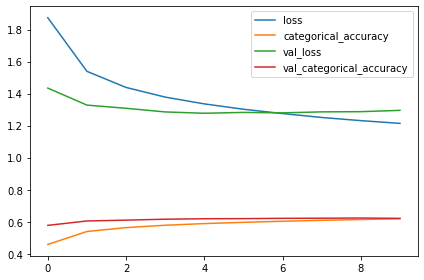

In [26]:
# Dense model 1, k=64, batch size = 1024, epochs = 10, 5 MB english text

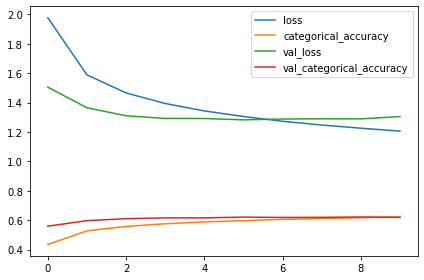

In [36]:
# Dense model 1, k=64, batch size = 2048, epochs 10, 5 MB English Text

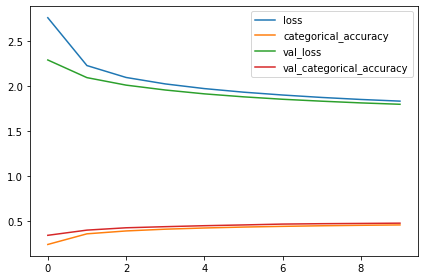

In [31]:
# Dense model 1, k=32, batch size=2048, epochs=10, 5 MB english text

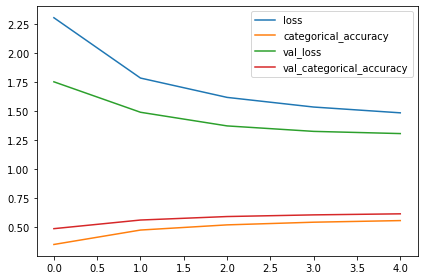

In [53]:
# Reccurent model 1, k=64, batch size = 2048, epochs 5, 5 MB English text

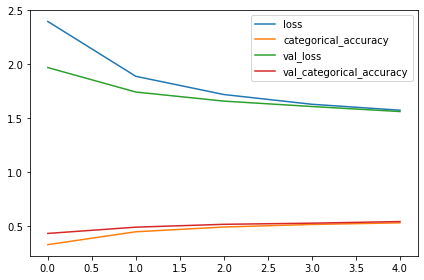

In [46]:
# Recurrent model 1, k=32, batch size=2048, epochs=5, 5 MB english text

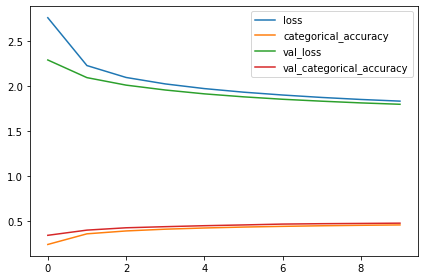

In [31]:
# Recurrent model 2, k=32,  batch size=2048, epochs=10, 5 MB english text